# LIMPIEZA DE DATOS GEOESPACIALES
Y ARMADO DE ARCHIVO.SHP

# DESAFIO 1 - GRUPO 1
df Properatti.csv

In [2]:
# importamos las librerias
import numpy as np              ;   import pandas as pd
import geopandas as gpd         ;   from shapely.geometry import Polygon, Point, LineString, LinearRing, MultiPolygon
import shapely as sp            ;   import matplotlib.pyplot as plt
import time                             ;   import unidecode
import re                               ;   import seaborn as sns
import shapely.wkt ; from shapely.ops import nearest_points as near
from shapely.ops import cascaded_union ; from IPython.display import display
import unidecode

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# definimos un par de funciones que nos ayudaran a medir tiempos
startAll = time.time()
def t():
    global start
    start = time.time()
def tt():
    end = time.time() ; minutos = int(round(end - start)/60) ; segundos = int(round(end - start)-(int(round(end - start)/60))*60) ;     tiempo = 'Esta celda tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo
def tiempo():
    endAll = time.time() ; minutos = int(round(endAll - startAll)/60) ; segundos = int(round(endAll - startAll)-(int(round(endAll - startAll)/60))*60) ;     tiempo = 'Desde el inicio, tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo

### parametros

In [4]:
# pausa en chequeos      # imprime mapas          # saltea procesos para agilizar
check = 'NO' ;             mapas = 'SI' ;           correr = 'SI'

In [5]:
def chequear():
    if check=='SI':
        input('presione enter para continuar...')

# PROPERATTI DATABASE

In [6]:
df = pd.read_csv('properatti.csv',sep=',',index_col=0)
df.shape

(121220, 25)

In [7]:
df.head(2)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


# LLAVE UNICA
se encuentra en la direccion URL un codigo embebido que distingue cada registro individualmente, igualmente según lo que comentó Elias, puede haber publicaciones de la misma propiedad en diferentes fechas, lo que nos dejaria registros duplicados igualmente

In [8]:
def get_codigo(data):
    data = data.strip('http://www.properati.com.ar/')
    return data.split('_')[0]

In [9]:
df.shape

(121220, 25)

In [10]:
len(df.properati_url.unique())

121220

In [11]:
df['id'] = df.properati_url.map(get_codigo)

In [12]:
len(df.id.unique())

121220

In [13]:
# todos son valores unicos
df.shape[0] == len(df.id.unique())

True

# MISSING DATA

In [14]:
# vemos el total de nulos del dataset
df.isna().sum()[df.isna().sum()>0]

place_name                        23
geonames_id                    18717
lat-lon                        51550
lat                            51550
lon                            51550
price                          20410
currency                       20411
price_aprox_local_currency     20410
price_aprox_usd                20410
surface_total_in_m2            39328
surface_covered_in_m2          19907
price_usd_per_m2               52603
price_per_m2                   33562
floor                         113321
rooms                          73830
expenses                      106958
description                        2
image_thumbnail                 3112
dtype: int64

### MISSING GEO-DATA

In [15]:
df.columns

Index(['operation', 'property_type', 'place_name', 'place_with_parent_names',
       'country_name', 'state_name', 'geonames_id', 'lat-lon', 'lat', 'lon',
       'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'price_per_m2', 'floor', 'rooms', 'expenses', 'properati_url',
       'description', 'title', 'image_thumbnail', 'id'],
      dtype='object')

In [16]:
# vemos que los faltantes de geolocalización no coinciden, asique hay esperanzas...
df.isna().sum()[['place_name','place_with_parent_names', 'country_name', 'state_name','geonames_id','lat-lon','lat','lon']]

place_name                    23
place_with_parent_names        0
country_name                   0
state_name                     0
geonames_id                18717
lat-lon                    51550
lat                        51550
lon                        51550
dtype: int64

### MAPA Argentina

In [17]:
# nos guardamos el crs que usaremos durante todo el notebook
crs = {'init': 'epsg:4326'}

In [18]:
# leo una cartografia de fondo
mapBase = gpd.read_file('carto/Codgeo/pxdptodatosok.shp')
mapBase.sample(3)
mapBase.crs = crs

In [19]:
# definimos una funcion para quitar acentos
def acentos_raros(data):
    try:         return data.replace('Ã³','ó').replace('Ã¡','á').replace('Ã­','í').replace('Ã©','e').replace('Ãº','ú').replace('Ã±','ñ').replace('Ã','Ñ')
    except:      pass

mapBase.departamen = mapBase.departamen.map(acentos_raros)
mapBase.provincia = mapBase.provincia.map(acentos_raros)
# quitamos la antartida
mapBase = mapBase.loc[(mapBase.departamen != 'Antártida Argentina')&(mapBase.departamen != 'Islas del Atlántico Sur')]

# solo queremos los nombres y poligonos, por lo que acortamos el dataframe a eso
mapBase = mapBase[['codpcia',  'provincia', 'departamen', 'geometry']]

In [20]:
mapBase.loc[mapBase.provincia == 'Neuquen','provincia'] = 'Neuquén'

In [21]:
# generamos con disolve unos dataframes especificos para solo provincias y solo Argentina
provincias = mapBase.dissolve('codpcia')
provincias = provincias.reindex(['pais','provincia','geometry'],axis=1)
provincias['pais'] = 'Agentina'
argentina = provincias.dissolve('pais')

#recortamos el mapa de buenos aires del total argentino
capitalMap = mapBase.loc[mapBase.codpcia == '02', :]

In [22]:
mapBase.head()

,codpcia,provincia,departamen,geometry
0,02,Ciudad Autónoma de Buenos Aires,Comuna 1,"POLYGON ((-58.37501 -34.57959, -58.36690 -34.5..."
1,02,Ciudad Autónoma de Buenos Aires,Comuna 2,"POLYGON ((-58.40084 -34.57126, -58.40005 -34.5..."
2,02,Ciudad Autónoma de Buenos Aires,Comuna 3,"POLYGON ((-58.39365 -34.60154, -58.39348 -34.6..."
3,02,Ciudad Autónoma de Buenos Aires,Comuna 4,"POLYGON ((-58.35695 -34.61980, -58.35672 -34.6..."
4,06,Buenos Aires,Berazategui,"POLYGON ((-58.01702 -34.78120, -58.08380 -34.8..."


In [23]:
argentina.bounds

,minx,miny,maxx,maxy
pais,,,,
Agentina,-73.572194,-55.057442,-53.642084,-21.745058


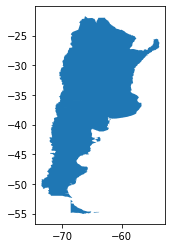

In [24]:
argentina.plot()

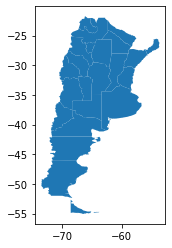

In [25]:
provincias.plot()

### Capital Federal
nuestro mapa recorta solo a nivel de columna, por lo que nos traemos el csv de barrios de la clase 13

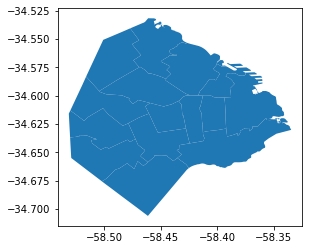

In [26]:
capitalMap.plot()

In [27]:
barrios = pd.read_csv('carto/barrios_capital.csv',sep=',',encoding='Latin1')

In [28]:
def from_wkt(df, wkt_column):
    # con wkt genero una columna
    df['geometry'] = df[wkt_column].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf

In [29]:
barrios = from_wkt(barrios, "WKT")

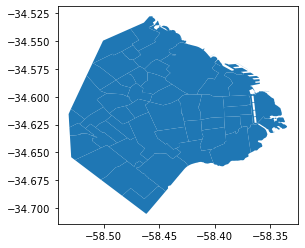

In [30]:
#ahora está mas segmentado

barrios.crs = crs
if correr == 'SI':
    barrios.plot()

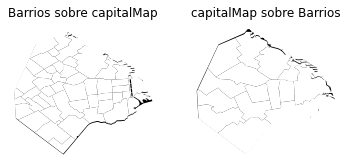

In [31]:
# hay un pequeño desfase... podemos vivir con eso... pero a tener en cuenta
if correr == 'SI':
    fig = plt.figure(figsize=(6,3)) ; ax = fig.add_subplot(1,2,1)
    capitalMap.plot(ax=ax,color='k')
    barrios.plot(ax=ax,color='w')
    ax.set_axis_off() ; ax.set_title('Barrios sobre capitalMap');

    ax = fig.add_subplot(1,2,2)
    barrios.plot(ax=ax,color='k')
    capitalMap.plot(ax=ax,color = 'w')
    ax.set_axis_off() ; ax.set_title('capitalMap sobre Barrios');

# geo recibida

In [32]:
# generamos una columna para luego discriminar las geometrias recibidas de las conseguidas
df['geo_ok'] = 0

df.loc[~np.isnan(df.lat),'geo_ok'] = 1 # lat-lon originales

In [33]:
# vemos las cantidades donde 1 es propia del dataset y 0 la conseguiremos
df['geo_ok'].value_counts()

1    69670
0    51550
Name: geo_ok, dtype: int64

In [34]:
df.columns=['operation','property_type','place_name','parent_names','country_name','state_name','geonames_id','lat-lon','lat','lon','price','currency','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','expenses','properati_url','description','title','image_thumbnail','id','geo_ok']

# normalizamos nombres de 'state_name' (provincia)

In [35]:
# debemos normalizar esta columna a las provincias que tengo en el mapa
df.state_name.unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Catamarca',
       'Santiago Del Estero', 'Jujuy', 'La Rioja', 'Formosa'],
      dtype=object)

In [36]:
# debemos normalizar esta columna a las provincias que tengo en el mapa
if correr == 'SI':
    en_df = list (df.state_name.unique())
    en_map = list(mapBase.provincia.unique())

    for i in range(len(en_df)):
        if en_df[i] in en_map:
            pass
        else: print(en_df[i])

Capital Federal
Bs.As. G.B.A. Zona Sur
Buenos Aires Costa Atlántica
Bs.As. G.B.A. Zona Norte
Bs.As. G.B.A. Zona Oeste
Buenos Aires Interior
Tierra Del Fuego
Santiago Del Estero


In [37]:
# para capital federal
df.loc[df.state_name == 'Capital Federal','state_name'] = 'Ciudad Autónoma de Buenos Aires'

# para buenos aires solo tenemos un valor
df.loc[(df.state_name == 'Bs.As. G.B.A. Zona Sur')       |
       (df.state_name == 'Buenos Aires Costa Atlántica') |
       (df.state_name == 'Bs.As. G.B.A. Zona Norte')     |
       (df.state_name == 'Bs.As. G.B.A. Zona Oeste')     |
       (df.state_name == 'Buenos Aires Interior')        , 'state_name'] = 'Buenos Aires'

# si posteriormente quisieramos recuperar estos valores podemos modificar esto.

# para capital federal es ciudad autonoma de buenos aires
df.loc[df.state_name == 'Capital Federal','state_name'] = 'Ciudad Autónoma de Buenos Aires'

# para TDF y SDE es solo la mayúscula del articulo
df.loc[df.state_name == 'Tierra Del Fuego','state_name'] = 'Tierra del Fuego'
df.loc[df.state_name == 'Santiago Del Estero','state_name'] = 'Santiago del Estero'

In [38]:
# volvemos a comprobar la consistencia
en_df = list (df.state_name.unique())
en_map = list(mapBase.provincia.unique())

for i in range(len(en_df)):
    if en_df[i] in en_map:
        pass
    else: print(en_df[i])

In [39]:
tiempo()

'Desde el inicio, tardo en ejecutar: 0 minutos, 11 segundos.'

# normalizando parent_names

In [40]:
# quitamos argentina, el strip no sirve por pilar|
df['parent_names'] = [df.parent_names.iloc[i].replace('|Argentina|','')[:len(df.parent_names.iloc[i].replace('|Argentina|',''))-1] for i in range(len(df))]

In [41]:
t()
df['parent_names'] = [df.parent_names.iloc[i].replace('Capital Federal','Ciudad Autónoma de Buenos Aires')\
                      .replace('Bs.As. G.B.A. Zona Sur','Buenos Aires')\
                      .replace('Buenos Aires Costa Atlántica','Buenos Aires')\
                      .replace('Bs.As. G.B.A. Zona Norte','Buenos Aires')\
                      .replace('Bs.As. G.B.A. Zona Oeste','Buenos Aires')\
                      .replace('Buenos Aires Interior','Buenos Aires')\
                      .replace('Tierra Del Fuego','Tierra del Fuego')\
                      .replace('Santiago Del Estero','Santiago del Estero') for i in range(len(df))]
tt()

'Esta celda tardo en ejecutar: 0 minutos, 2 segundos.'

# Primero comprobamos las ok
nos basamos en esos datos para completar el resto, pero hemos descubierto errores que nos completarán errores luego

# COMPROBAMOS LOS RESULTADOS

In [42]:
# lo armamos en una funcion ya que lo vamos a usar mucho... la expandemos un poco para que aplique tb a GeoNames
def set_geodf(dataFrame):
    global geodf_test
    try:
        geodf_test = dataFrame.loc[dataFrame.geo_ok != 0][['place_name', 'state_name', 'lat', 'lon', 'geo_ok']]
    except:
        geodf_test = dataFrame
    
    geodf_test.reset_index(inplace=True)
    # generamos el GeoDataFrame
    geodf_test = gpd.GeoDataFrame(geodf_test,crs=crs)
  
    try:
        # armamos los puntos con lat-lon
        geodf_test['geometry'] = geodf_test.index.map(lambda x: Point(geodf_test.lon.iloc[x],geodf_test.lat.iloc[x]))
    except:
        geodf_test['geometry'] = geodf_test.index.map(lambda x: Point(geodf_test.longitude.iloc[x],geodf_test.latitude.iloc[x]))

    try:
        geodf_test.columns = ['index_df', 'place_name', 'state_name', 'lat', 'lon', 'geo_ok','geometry']
    except: pass
    
    return len(geodf_test),'puntos.'

In [43]:
t()
# ahora para setear geodf_test solo tenemos que llamar a la funcion, la cual retornara el largo del df
set_geodf(df)
tt()

'Esta celda tardo en ejecutar: 0 minutos, 4 segundos.'

In [44]:
tiempo()

'Desde el inicio, tardo en ejecutar: 0 minutos, 21 segundos.'

In [45]:
# seteamos un listado de provincias que usaremos mucho
prov_names = list(geodf_test.state_name.unique())
# el buffer establecerá un limite al rededor del permietro para desestimar dichos puntos
prov_buffer = 0.5

# ploteamos para combrobar la geometria recibida

# GEOLOCALIZACION

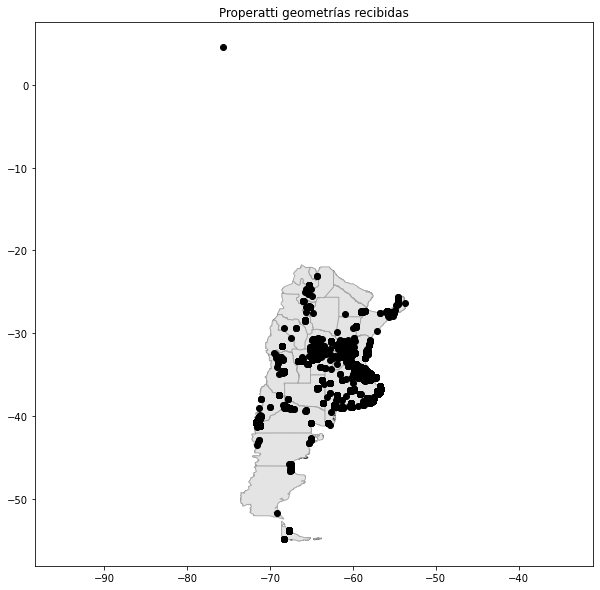

In [46]:
if mapas == 'SI':
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)

    provincias.plot(ax=ax,alpha=0.4,color='white',edgecolor='black')
    argentina.plot(ax=ax,alpha=0.6,color='lightgrey')
    #ploteamos el valor que ya sabemos erroneo
    geodf_test.plot(ax=ax,color='black')

  #  ax.set_axis_off()
    plt.axis('equal')
    ax.set_title('Properatti geometrías recibidas');

In [47]:
# definimos una funcion que nos plotee el mapa de la provincia y los puntos asociados a ella
def ver_prov(prov_ver):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    
    for i in range(len(prov_names)):
        if prov_names[i] == prov_ver:
            prov_id = prov_names[i]

    prov = prov_id
    
    global prov_buffer
    #provincias.loc[provincias.provincia == prov].convex_hull.buffer(prov_buffer).plot(ax=ax,alpha=0.4,color='white',edgecolor='black')
    
    provincias.loc[provincias.provincia == prov].plot(ax=ax,alpha=0.4,color='lightgrey',edgecolor='black')
    #argentina.plot(ax=ax,alpha=0.6,color='red')
    #ploteamos el valor que ya sabemos erroneo
    geodf_test.loc[geodf_test.state_name == prov].plot(ax=ax)

    #ax.set_axis_off()
    plt.axis('equal')
    ax.set_title('Fuera del shape de {}'.format(prov));

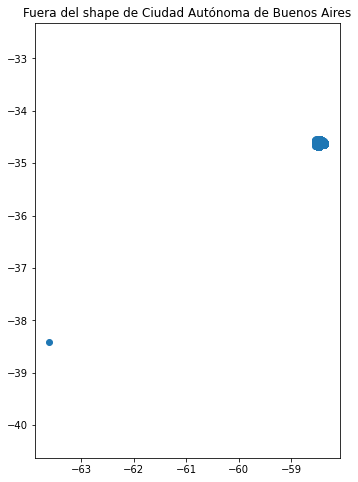

In [48]:
if mapas == 'SI':
    ver_prov('Ciudad Autónoma de Buenos Aires')

#  hay muchos puntos fuera de su provincia
da igual si es inventada o erronea, por lo que borramos esos puntos y luego les cargamos uno más acorde

In [49]:
# con este loop comprobamos que todos los puntos correspondan a su provincia
# este también será util mas adelante, lo definimos en una funcion
def loop_check(geoPuntos):
    '''
    esta función pide un dataset de puntos y devuelve según el mapa de provincias cuales coinciden
    '''
    global prov_names # debo llamar a la lista global
    global provincias # debo llamar al geodataset de geometrías de las provincias
    for i in range(len(prov_names)):
        prov = prov_names[i]
        puntos_prov = geoPuntos.loc[geoPuntos.state_name == prov]
        provincia = provincias.loc[provincias.provincia == prov]

        inside = list(gpd.sjoin(provincia,puntos_prov,how='inner').index_right)
        inside = puntos_prov.loc[inside]
        
        puntos_fuera = puntos_prov.loc[~(puntos_prov.index_df.isin(inside.index_df))]

        if len(puntos_fuera) > 0:
            print(prov)
        else:
            print("{0:33} {1}".format(prov, 'ok'))

In [50]:
if correr == 'SI':
    loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires
Buenos Aires
Entre Ríos
Santa Fe
Córdoba
Misiones
Salta
Neuquén                           ok
Río Negro
San Luis                          ok
Mendoza
Corrientes                        ok
Chubut
Tucumán
La Pampa                          ok
Chaco                             ok
San Juan
Santa Cruz
Tierra del Fuego
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [51]:
chequear()

### capital federal

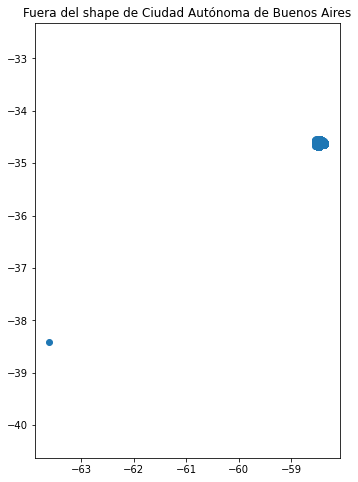

In [52]:
id_prov = prov_names[0]
if mapas == 'SI':
    ver_prov(id_prov)

In [53]:
puntos = geodf_test.loc[geodf_test.state_name == id_prov]    # seteamos un df con os pountos pertenecientes a la provincia
provincia = provincias.loc[provincias.provincia == id_prov]  # aqui guardamos el nombre de la provincia

inside = list(gpd.sjoin(puntos,provincia,how='inner').index) # mediante un sjoin vemo que cae dentro de la geometria

puntos_fuera = puntos.loc[(~puntos.index.isin(inside))]      # con una seleccion inversa vemos que cae fuera
puntos_fuera.shape

(57, 7)

### ahora corremos el loop

In [54]:
prov_buffer = 0.01 # ahora achicamos el buffer

[0, 'Ciudad Autónoma de Buenos Aires', 43, 'reseteados']
[1, 'Buenos Aires', 93, 'reseteados']
[2, 'Entre Ríos', 2, 'reseteados']
[3, 'Santa Fe', 2, 'reseteados']
[4, 'Córdoba', 12, 'reseteados']
[5, 'Misiones', 7, 'reseteados']
[6, 'Salta', 1, 'reseteados']
[8, 'Río Negro', 2, 'reseteados']
[10, 'Mendoza', 1, 'reseteados']
[13, 'Tucumán', 3, 'reseteados']
[16, 'San Juan', 1, 'reseteados']
[17, 'Santa Cruz', 1, 'reseteados']


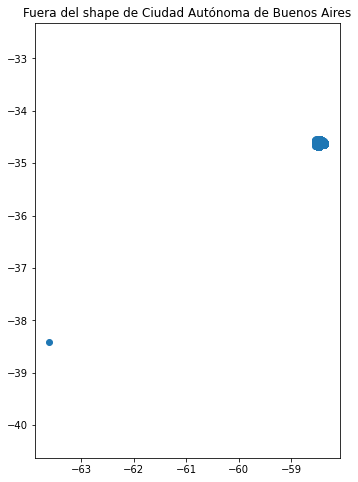

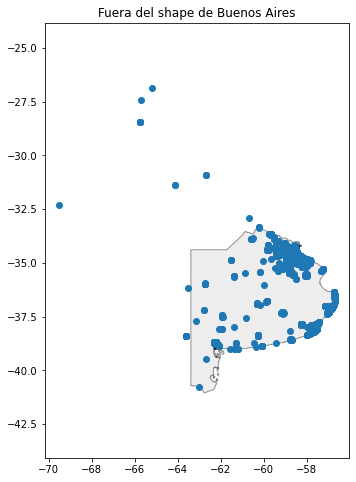

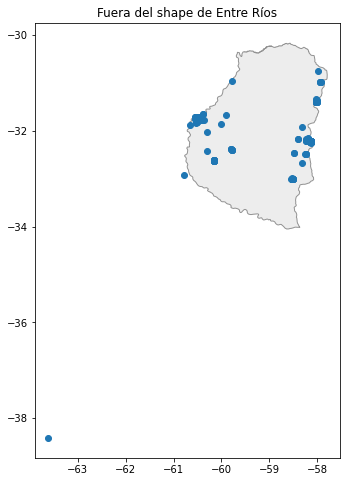

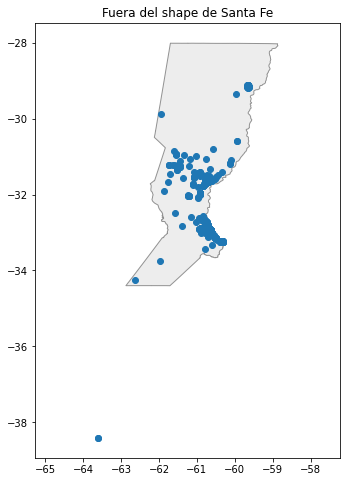

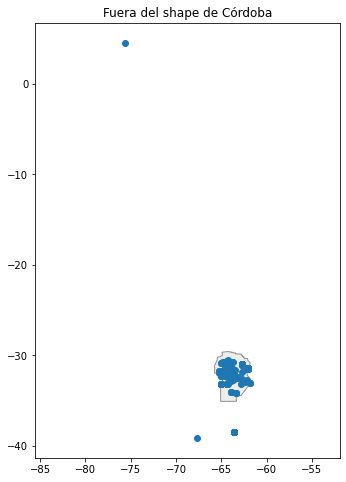

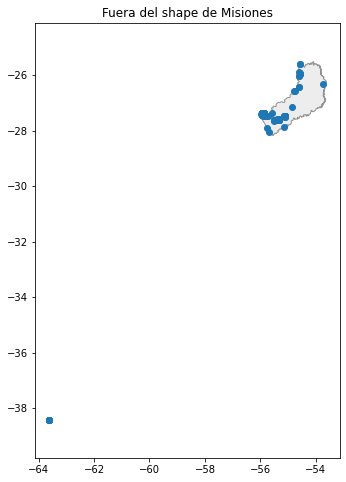

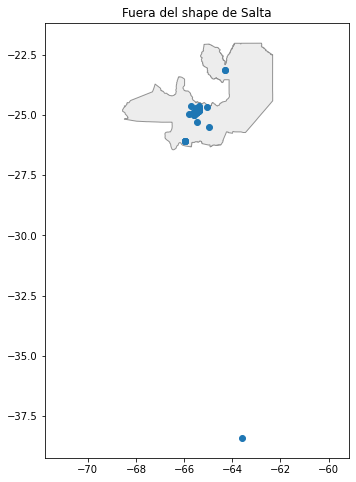

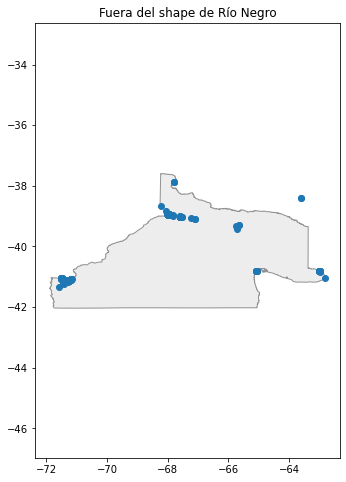

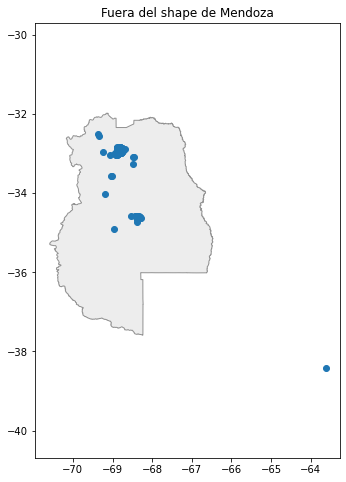

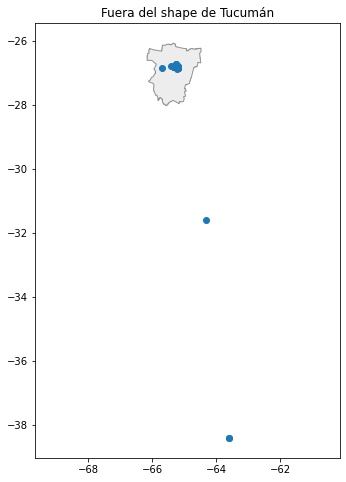

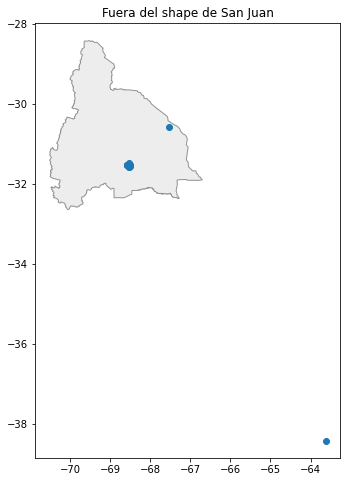

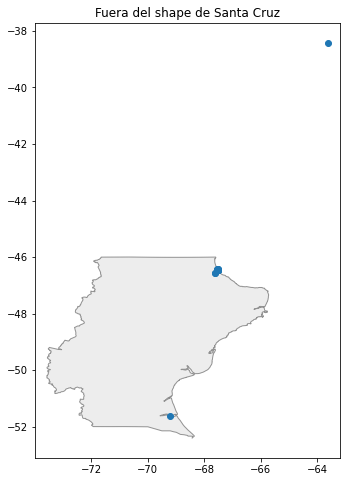

In [55]:
puntos_reseteados = []

for i in range(len(prov_names)):
    # establecemos la provincia
    id_prov = prov_names[i]

    # nos guardamos los puntos correspondientes a la provincia
    puntos = geodf_test.loc[geodf_test.state_name == id_prov]
    puntos.reset_index(drop=True,inplace=True)
    puntos.columns = ['index_df', 'place_name', 'state_name', 'lat', 'lon', 'geo_ok','geometry']
    # nos guardamos el mapa de la provincia
    provincia = provincias.loc[provincias.provincia == id_prov]

    area_quitar = provincia.geometry[0].convex_hull.buffer(prov_buffer)
    area_quitar = gpd.GeoDataFrame([area_quitar],[0],['geometry'],crs=crs)

    # verificamos que puntos se superponen con el shape de la provincia
    inside = gpd.sjoin(area_quitar,puntos,how='inner')
    inside.reset_index(drop=True,inplace=True)
    
    # nos guardamos los puntos que no se superponen
    puntos_fuera = puntos.loc[~(puntos.index_df.isin(inside.index_df))]
    
    if len(puntos_fuera) > 0:
        print([i,id_prov,len(puntos)-len(inside),'reseteados'])
        if mapas == 'SI':
            ver_prov(id_prov)

    # finalmente reseteamos lat-lon en df
    
    df.loc[list(puntos_fuera['index_df']),'lat'] = np.nan
    df.loc[list(puntos_fuera['index_df']),'lon'] = np.nan
    df.loc[list(puntos_fuera['index_df']),'geo_ok'] = 0 # los eliminados pasan a 0

In [56]:
tiempo()

'Desde el inicio, tardo en ejecutar: 0 minutos, 46 segundos.'

# volvemos a procesar geodf_test
quitando las reseteadas

In [57]:
set_geodf(df)

(69502, 'puntos.')

In [58]:
if correr == 'SI':
    for i in range(len(prov_names)):
        # establecemos la provincia
        id_prov = prov_names[i]

        # nos guardamos los puntos correspondientes a la provincia
        puntos = geodf_test.loc[geodf_test.state_name == id_prov]
        puntos.reset_index(drop=True,inplace=True)
        puntos.columns = ['index_df', 'place_name', 'state_name', 'lat', 'lon', 'geo_ok','geometry']
        # nos guardamos el mapa de la provincia
        provincia = provincias.loc[provincias.provincia == id_prov]

        area_quitar = provincia.geometry[0].convex_hull.buffer(prov_buffer)
        area_quitar = gpd.GeoDataFrame([area_quitar],[0],['geometry'],crs=crs)

        # verificamos que puntos se superponen con el shape de la provincia
        inside = gpd.sjoin(area_quitar,puntos,how='inner')
        inside.reset_index(drop=True,inplace=True)

        # nos guardamos los puntos que no se superponen
        puntos_fuera = puntos.loc[~(puntos.index_df.isin(inside.index_df))]

        if len(puntos_fuera) > 0:
            print([i,id_prov,len(puntos)-len(inside),'reseteados'])
            if mapas =='SI':
                ver_prov(id_prov)

        # finalmente reseteamos lat-lon en df

        df.loc[list(puntos_fuera['index_df']),'lat'] = np.nan
        df.loc[list(puntos_fuera['index_df']),'lon'] = np.nan
        df.loc[list(puntos_fuera['index_df']),'geo_ok'] = 0

    # si funcionó bien, no devuelve nada....

# igualmente, hay puntos dentro del hull pero fuera de la geometria
estan muy cerca de la geometría, intentaremos acercarlos a ella.

In [59]:
prov = prov_names[1]

puntos_test = geodf_test.loc[geodf_test.state_name == prov]

provincia = provincias.loc[provincias.provincia == prov]

inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right)
inside = puntos_test.loc[inside]

puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]

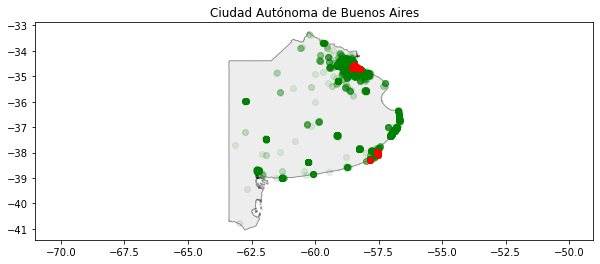

In [60]:
if mapas == 'SI':
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,1,1)

    provincia.plot(ax=ax,alpha=0.4,color='lightgrey',edgecolor='black')

    inside.plot(ax=ax,color='g',alpha=0.1)

    puntos_fuera.plot(ax=ax,color='r')

   # ax.set_axis_off()
    plt.axis('equal')
    ax.set_title('Ciudad Autónoma de Buenos Aires');

# obtener lineas de perimetro

In [61]:
# para proyectar sobre una linea, necesitamos los perimetros de las provincias
prov_lines = provincias.copy()
prov_lines.reset_index(drop=True,inplace=True)
# con los multipoligonos es diferente, debemos calcularlos de otra manera
multis = prov_lines.loc[[1,6,19,23]]

In [62]:
# esto nos permite obtener los perimetros de los Multipoligonos
for i in range(len(multis)):
    
    pol1 = multis.iloc[i].geometry
    pol2 = multis.iloc[i].geometry.buffer(1.0)
    pols = [pol1, pol2]

    lines = []
    for pol in pols:
        boundary = pol.boundary
        if boundary.type == 'MultiLineString':
            for line in boundary:
                lines.append(line)
        else:
            lines.append(line)

    for line in lines:
        multis.geometry.iloc[i] = LinearRing(line)

In [63]:
# en este loop obtenemos los permietros, por un lado si son multipoligonos y else si son poligonos
for i in range(len(prov_lines)):
    if prov_lines.provincia.iloc[i] in multis.provincia.unique():
        prov_lines.loc[i,'geometry'] = multis.loc[i].geometry
    else:
        prov_lines.loc[i,'geometry'] = LinearRing(prov_lines.loc[i].geometry.exterior)

# moviendo los puntos

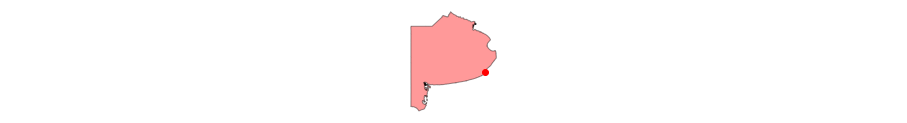

In [64]:
# vemos un caso
puntos_fuera.reset_index(drop=True,inplace=True)
uno = puntos_fuera.loc[[0]]

if mapas == 'SI':
    # está muy cerca, pero igual está fuera de la geometría... intentaremos ponerlo sobre ella.
    fig = plt.figure(figsize=(16,2)) ; ax = fig.add_subplot(1,1,1)
    provincia.plot(ax=ax,alpha=0.4,color='red',edgecolor='black')
    uno.plot(ax=ax,color='r')
    ax.set_axis_off() ; plt.axis('equal');

In [65]:
prov = provincias.loc[provincias.provincia == 'Buenos Aires']

# no es mucha, pero hay distnacia, simplemente con esta distancia ya lo deja fuera en un sjoin
prov.geometry[0].distance(uno.geometry[0])

0.0005890632608093664

In [66]:
provincia = provincias.loc[['06']]
prov_line= prov_lines.loc[1].geometry
provincia

,pais,provincia,geometry
codpcia,,,
06,Agentina,Buenos Aires,"MULTIPOLYGON (((-62.08311 -40.25962, -62.08219..."


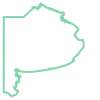

In [67]:
prov_line

In [68]:
uno_geo = uno.geometry[0]
uno

,index_df,place_name,state_name,lat,lon,geo_ok,geometry
0,667,Mar del Plata,Buenos Aires,-38.008721,-57.536116,1,POINT (-57.53612 -38.00872)


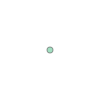

In [69]:
uno_geo

In [70]:
poly = prov_line
point = uno_geo


d = poly.project(point)
p = poly.interpolate(d)
closest_coords = list(p.coords)[0]

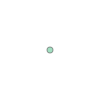

In [71]:
Point(closest_coords)

In [72]:
test = gpd.GeoDataFrame([Point(closest_coords)],[0],['geometry'],crs = crs)

In [73]:
# ahora el punto calza sobre la geometría... EXITO!!!, veamos si funciona para todos
gpd.sjoin(test,provincia,how='inner')

,geometry,index_right,pais,provincia
0,POINT (-57.53643 -38.00922),06,Agentina,Buenos Aires


In [74]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 3 segundos.'

# funciona!!! ahora a loopearlo

In [75]:
for i in range(len(prov_names)):
    prov = prov_names[i]
    puntos_prov = geodf_test.loc[geodf_test.state_name == prov]

    prov_map = provincias.loc[provincias.provincia == prov]
    prov_line = prov_lines.loc[prov_lines.provincia == prov].geometry.iloc[0]

    inside = list(gpd.sjoin(prov_map,puntos_prov,how='inner').index_right)
    puntos_in = puntos_prov.loc[inside]

    puntos_out = puntos_prov.loc[~puntos_prov.index.isin(inside)].copy()
    puntos_out.reset_index(drop=True,inplace=True)

    for x in range(len(puntos_out)):
        poly = prov_line
        point = puntos_out.loc[x].geometry

        d = poly.project(point)
        p = poly.interpolate(d)
        closest_coords = list(p.coords)[0]

        df.loc[puntos_out.index_df.iloc[x],'lat'] = Point(closest_coords).y
        df.loc[puntos_out.index_df.iloc[x],'lon'] = Point(closest_coords).x
        
        df.loc[puntos_out.index_df.iloc[x],'geo_ok'] = 2 # los puntos que movimos quedan en 2

### inexplicablemente funciona solo para la mitad

In [76]:
eran = len(puntos_fuera)

In [77]:
set_geodf(df)

(69502, 'puntos.')

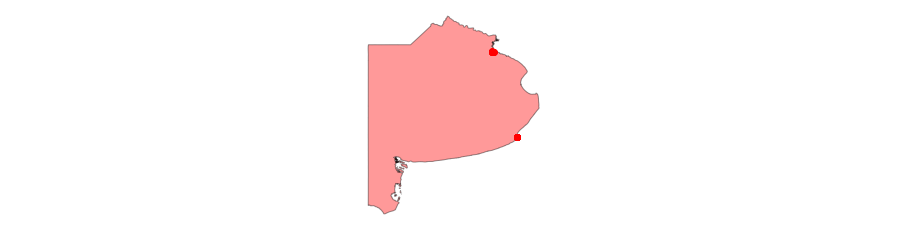

In [78]:
if correr=='SI':
    prov = prov_names[1]

    puntos_test = geodf_test.loc[geodf_test.state_name == prov]

    provincia = provincias.loc[provincias.provincia == prov]

    inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right)
    inside = puntos_test.loc[inside]

    puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]

    # definimos una funcion que nos plotee el mapa de la provincia y los puntos asociados a ella
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(1,1,1)

    provincia.plot(ax=ax,alpha=0.4,color='red',edgecolor='black')

    #inside.plot(ax=ax,color='g',alpha=0.1)

    puntos_fuera.plot(ax=ax,color='r')

    ax.set_axis_off()
    plt.axis('equal');

In [79]:
print('eran',eran,'son',len(puntos_fuera))

eran 73 son 31


# vemos a mano los restantes

In [80]:
# capital Federal
prov = prov_names[0]

puntos_test = geodf_test.loc[geodf_test.state_name == prov]

provincia = provincias.loc[provincias.provincia == prov]

inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right)
inside = puntos_test.loc[inside]

puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]

# solo queremos ver las no duplicadas
puntos_fuera_plot = puntos_fuera.drop_duplicates(subset='geometry')

len(puntos_fuera)

7

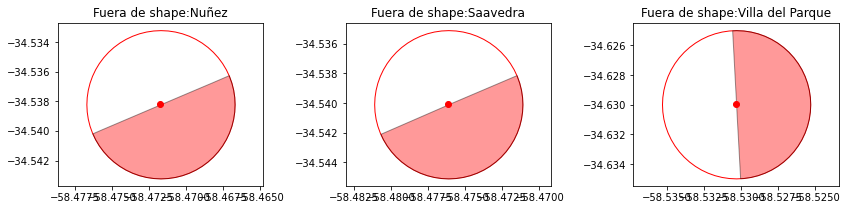

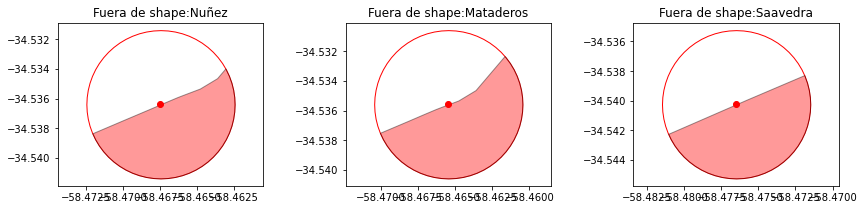

In [81]:
# definimos un loop para analizar estas mini diferencias, esto lo haremos para cada provincia, 
# pero luego eliminamos este loop y el analisis de las provincias en 0 fuera del mapa
zoom = 0.005

for i in range(0,len(puntos_fuera_plot),3):
    try:
        test1 = puntos_fuera_plot.iloc[[i]]
        title1 = test1.place_name.iloc[0]
        perimetro1 = test1.geometry.iloc[0].buffer(zoom)
        per_df1 = gpd.GeoDataFrame({'geometry':[perimetro1]},crs=crs)
        per_map1 = gpd.overlay(provincia, per_df1, how='intersection')

        fig = plt.figure(figsize=(14,3))
        ax1 = fig.add_subplot(1,3,1)
        per_df1.plot(ax=ax1,color='w',edgecolor='r')
        per_map1.plot(ax=ax1,alpha=0.4,color='red',edgecolor='black')
        test1.plot(ax=ax1,color='r')
        plt.axis('equal');
        ax1.set_title('Fuera de shape:{}'.format(title1));
    except:
        break
    try:
        test2 = puntos_fuera_plot.iloc[[i+1]]
        title2 = test2.place_name.iloc[0]
        perimetro2 = test2.geometry.iloc[0].buffer(zoom)
        per_df2 = gpd.GeoDataFrame({'geometry':[perimetro2]},crs=crs)
        per_map2 = gpd.overlay(provincia, per_df2, how='intersection')

        ax2 = fig.add_subplot(1,3,2)
        per_df2.plot(ax=ax2,color='w',edgecolor='r')
        per_map2.plot(ax=ax2,alpha=0.4,color='red',edgecolor='black')
        test2.plot(ax=ax2,color='r')
        plt.axis('equal');
        ax2.set_title('Fuera de shape:{}'.format(title2));
    except:
        break
    try:
        test3 = puntos_fuera_plot.iloc[[i+2]]
        title3 = test3.place_name.iloc[0]
        perimetro3 = test3.geometry.iloc[0].buffer(zoom)
        per_df3 = gpd.GeoDataFrame({'geometry':[perimetro3]},crs=crs)
        per_map3 = gpd.overlay(provincia, per_df3, how='intersection')

        ax3 = fig.add_subplot(1,3,3)
        per_df3.plot(ax=ax3,color='w',edgecolor='r')
        per_map3.plot(ax=ax3,alpha=0.4,color='red',edgecolor='black')
        test3.plot(ax=ax3,color='r')

        plt.axis('equal');
        ax3.set_title('Fuera de shape:{}'.format(title3));
        plt.subplots_adjust(hspace=0.4,wspace=0.4)
    except:
        break

In [82]:
# podemos correr todos para el mismo lado
#df.loc[list(puntos_fuera.index_df),'lat'] -= 0.0005
df.loc[list(puntos_fuera.index_df),'lon'] += 0.0005

df.loc[list(puntos_fuera.index_df),'geo_ok'] = 2

### buenos aires

In [83]:
prov = prov_names[1] ; puntos_test = geodf_test.loc[geodf_test.state_name == prov]
provincia = provincias.loc[provincias.provincia == prov]
inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right) ; inside = puntos_test.loc[inside]
puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]
# solo queremos ver las no duplicadas
puntos_fuera_plot = puntos_fuera.drop_duplicates(subset='geometry') ; len(puntos_fuera)

31

### los corremos un poquito

In [84]:
df.loc[list(puntos_fuera.index_df),'lat'] -= 0.00005
df.loc[list(puntos_fuera.index_df),'lon'] -= 0.00005

df.loc[list(puntos_fuera.index_df),'geo_ok'] = 2

### Santa Cruz

In [85]:
prov = prov_names[17] ; puntos_test = geodf_test.loc[geodf_test.state_name == prov]
provincia = provincias.loc[provincias.provincia == prov]
inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right) ; inside = puntos_test.loc[inside]
puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]
# solo queremos ver las no duplicadas
puntos_fuera_plot = puntos_fuera.drop_duplicates(subset='geometry') ; print(prov,len(puntos_fuera))

Santa Cruz 2


### los corremos un poquito

In [86]:
df.loc[list(puntos_fuera.index_df),'lat'] -= 0.00005
df.loc[list(puntos_fuera.index_df),'lon'] -= 0.00005

df.loc[list(puntos_fuera.index_df),'geo_ok'] = 2

### Tierra del Fuego

In [87]:
prov = prov_names[18] ; puntos_test = geodf_test.loc[geodf_test.state_name == prov]
provincia = provincias.loc[provincias.provincia == prov]
inside = list(gpd.sjoin(provincia,puntos_test,how='inner').index_right) ; inside = puntos_test.loc[inside]
puntos_fuera = puntos_test.loc[~(puntos_test.index_df.isin(inside.index_df))]
# solo queremos ver las no duplicadas
puntos_fuera_plot = puntos_fuera.drop_duplicates(subset='geometry') ; print(prov,len(puntos_fuera))

Tierra del Fuego 1


### los corremos un poquito

In [88]:
df.loc[list(puntos_fuera.index_df),'lat'] -= 0.00005
df.loc[list(puntos_fuera.index_df),'lon'] -= 0.00005

df.loc[list(puntos_fuera.index_df),'geo_ok'] = 2

In [89]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 20 segundos.'

# ya todos nuestros puntos corresponden a su geometria

In [90]:
set_geodf(df)

(69502, 'puntos.')

In [91]:
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires   ok
Buenos Aires                      ok
Entre Ríos                        ok
Santa Fe                          ok
Córdoba                           ok
Misiones                          ok
Salta                             ok
Neuquén                           ok
Río Negro                         ok
San Luis                          ok
Mendoza                           ok
Corrientes                        ok
Chubut                            ok
Tucumán                           ok
La Pampa                          ok
Chaco                             ok
San Juan                          ok
Santa Cruz                        ok
Tierra del Fuego                  ok
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [92]:
chequear()

In [93]:
tiempo()

'Desde el inicio, tardo en ejecutar: 1 minutos, 29 segundos.'

# para los que borramos o nunca tuvieron

# loop, imputando por random number para todos los parent_names iguales

aqui vemos un caso sin tenemos geometría


,lat,lon,geo_ok,parent_names
12409,-38.008954,-57.53697,1,Buenos Aires|Mar del Plata|Torreón



para el loc de este parent_names tenemos, max_lat -38.00870675
para el loc de este parent_names tenemos, max_lat -38.0109504921
con un rango entre ellas de 0.002243742099999224

la media es -38.00949171204263

el desvío 0.0006612921344411613

y nuestro random nos otorga


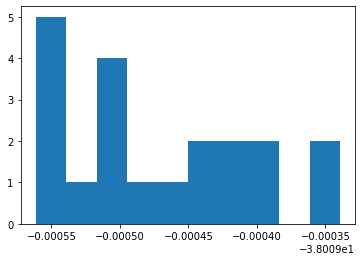

In [94]:
if correr == 'SI':
    print('aqui vemos un caso sin tenemos geometría')
    display(df.loc[[12409]][['lat','lon','geo_ok','parent_names']])

    parent1 = 'Buenos Aires|Mar del Plata|Torreón'
    print('')
    print('para el loc de este parent_names tenemos, max_lat',df.loc[df.parent_names == parent1 ].lat.max())
    print('para el loc de este parent_names tenemos, max_lat',df.loc[df.parent_names == parent1 ].lat.min())

    rango = df.loc[df.parent_names == parent1 ].lat.max() - df.loc[df.parent_names == parent1 ].lat.min()
    print('con un rango entre ellas de',rango) ; print('')

    # sin embargo, con el mismo paren_name si hay geometrías, obtendremos esos promedios "dinamicamente"
    mean = df.loc[df.parent_names == parent1 ].lat.mean()
    print('la media es',mean);print('')

    std = df.loc[df.parent_names == parent1 ].lat.std()
    print('el desvío',std);print('')

    # vemos que los cambios son minimos, pero asi no nos caen todos juntos
    print('y nuestro random nos otorga')
    plt.hist(np.random.normal(loc= mean,scale=std/10,size=20))        # la variaza es minima, pero suficiente

In [95]:
# acortamos nuestro df a lo que vamos a buscar
inventadas = df.loc[np.isnan(df.lat)][['parent_names','lat','lon','id']]
inventadas.reset_index(inplace=True)
inventadas.columns = ['index_df','parent_names','lat', 'lon', 'id']
inventadas.head()

,index_df,parent_names,lat,lon,id
0,13,Ciudad Autónoma de Buenos Aires|Palermo|Palerm...,NaN,NaN,15bp9
1,14,Ciudad Autónoma de Buenos Aires|Palermo|Palerm...,NaN,NaN,15bpa
2,23,Buenos Aires|Pilar|Pilar,NaN,NaN,15bqt
3,42,Buenos Aires|Pilar,NaN,NaN,15btc
4,49,Buenos Aires|Escobar,NaN,NaN,15bu6


# loop para completar lat-lon

In [96]:
# el punto de control nos indica el progreso... es para evitar pensar que colgó...
control = 5000      ;      np.random.seed(2) # establezco una semilla para que no me varien los random
# tenemos que agilizar este loop, demora 1.5 minutos
t()
print('eran',inventadas.shape[0],'sin geometria')                   # contamos cuantas nos faltaban
for i in range(len(inventadas)):
    if i % control == 0:                                            # cuando el resto de i/control es 0, imprime i
        print(i,'procesadas')    
    if np.isnan(inventadas.lat.iloc[i]):                            # si el valor de lat es nulo
        value = inventadas.parent_names.iloc[i]                     # establecemos value con su parent_name
        if len(df.loc[df.parent_names == value ]) > 2:              # necesito al menos 3 valores, un nan y dos mas
            for x in ['lat','lon']:                                 # para lat y para lon 
                mean = df.loc[df.parent_names == value ][x].mean()  # calculamos la media de ese parent_name
                std = df.loc[df.parent_names == value ][x].std()    # calculamos su desvio
                inventadas.loc[inventadas.parent_names == value,x] = np.random.normal(loc= mean,scale=std/10) # los random
        else: pass                                                  # si no hay al menos 3 valores, no hace nada
    else: pass                                                      # si lat no es nulo, no hace nada
print('quedan',inventadas.loc[inventadas['lat'].isnull()].shape[0],'sin geometria')
tt()

eran 51718 sin geometria
0 procesadas
5000 procesadas
10000 procesadas
15000 procesadas
20000 procesadas
25000 procesadas
30000 procesadas
35000 procesadas
40000 procesadas
45000 procesadas
50000 procesadas
quedan 1062 sin geometria


'Esta celda tardo en ejecutar: 1 minutos, 21 segundos.'

### volcamos  a df

In [97]:
inv_ok = inventadas.loc[~np.isnan(inventadas.lat)]
inv_ok.reset_index(drop=True,inplace=True)

inv_ok = inv_ok.drop_duplicates(subset='parent_names')

In [98]:
inv_ok_dic = {inv_ok.parent_names.iloc[i] : [inv_ok.lat.iloc[i],inv_ok.lon.iloc[i]] for i in range(len(inv_ok))}

### podemos pisar informacion segun parent_names

In [99]:
# al generar los puntos está redondeando, este redondeo hace que algunos puntos pierdan dispersion
inv_ok_dic['Santa Fe|Rosario']

[-32.94732592029062, -60.66083716220143]

In [100]:
# vamos a truncar esos decimales, sin redondear
float(str(inv_ok_dic['Santa Fe|Rosario'][0])[:10])

-32.947325

In [101]:
parents = list(inv_ok.parent_names.unique()) # solo vamos a correr nuestro dic en los parent_names de inventadas
len(parents)

540

In [102]:
for i in range(len(parents)):
    df.loc[(df.parent_names == parents[i]) & (np.isnan(df.lat)),'lon'] = float(str(inv_ok_dic[parents[i]][1])[:10])
    df.loc[(df.parent_names == parents[i]) & (np.isnan(df.lat)),'geo_ok'] = 3 # las calculadas matematicamente
    df.loc[(df.parent_names == parents[i]) & (np.isnan(df.lat)),'lat'] = float(str(inv_ok_dic[parents[i]][0])[:10])

# testing

In [103]:
# no faltan lats para geo_ok 1, 2 y 3
df.loc[df.geo_ok != 0].loc[np.isnan(df.lat)]

,operation,property_type,place_name,parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,id,geo_ok


In [104]:
# no faltan longs
df.loc[df.geo_ok != 0].loc[np.isnan(df.lon)]

,operation,property_type,place_name,parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,id,geo_ok


### actualizo el geodf

In [105]:
set_geodf(df)

(120158, 'puntos.')

In [106]:
# comprobamos que todos hayan caido en su provincia
#if correr=='SI':
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires   ok
Buenos Aires
Entre Ríos                        ok
Santa Fe
Córdoba                           ok
Misiones                          ok
Salta                             ok
Neuquén                           ok
Río Negro                         ok
San Luis                          ok
Mendoza                           ok
Corrientes                        ok
Chubut                            ok
Tucumán                           ok
La Pampa                          ok
Chaco                             ok
San Juan                          ok
Santa Cruz                        ok
Tierra del Fuego                  ok
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [107]:
tiempo()

'Desde el inicio, tardo en ejecutar: 3 minutos, 22 segundos.'

### visualizamos la situacion por provincia

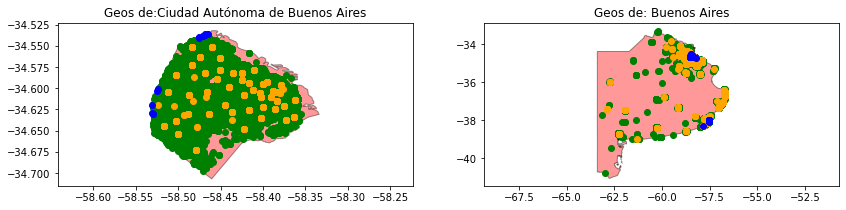

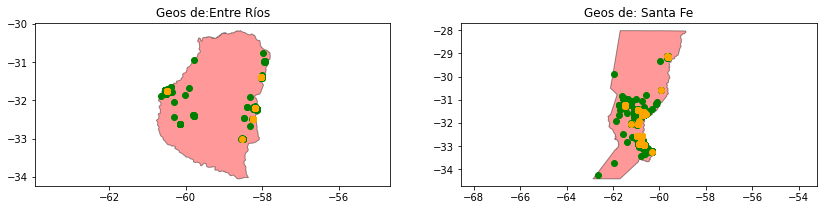

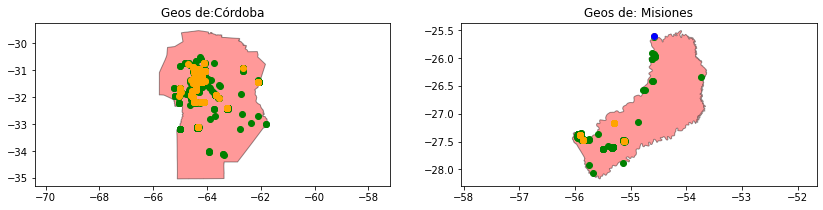

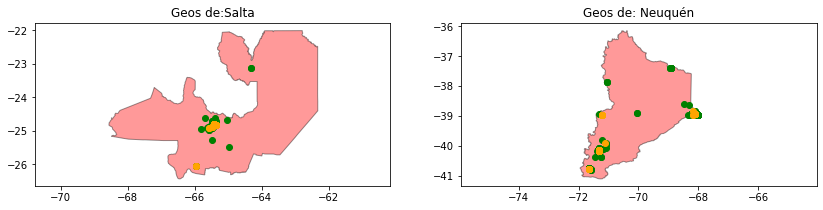

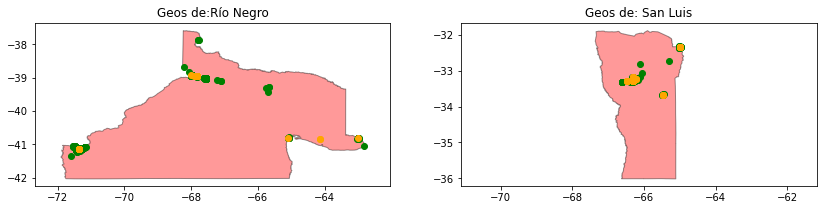

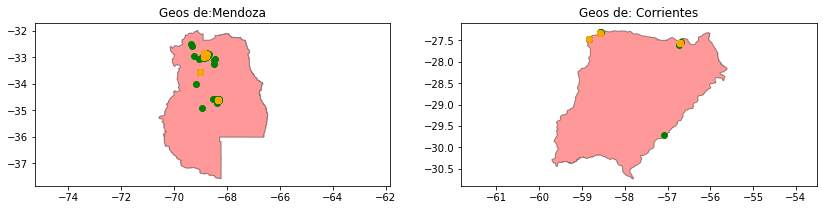

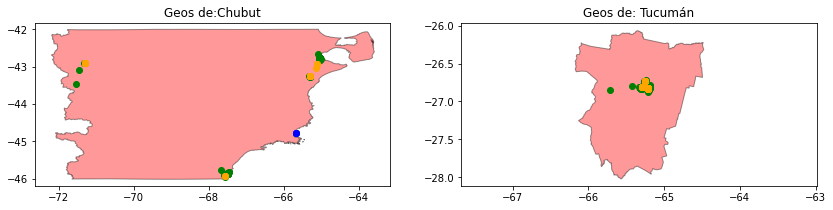

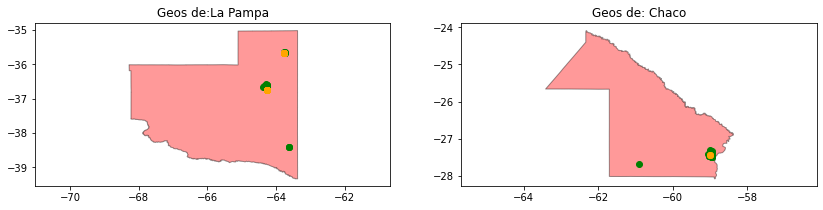

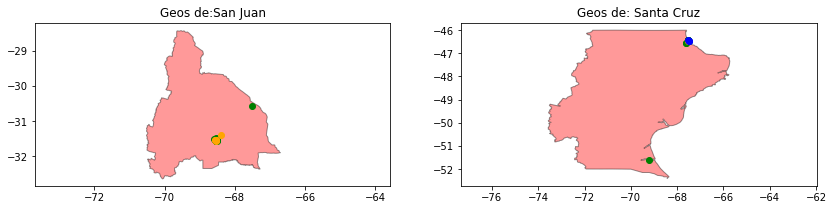

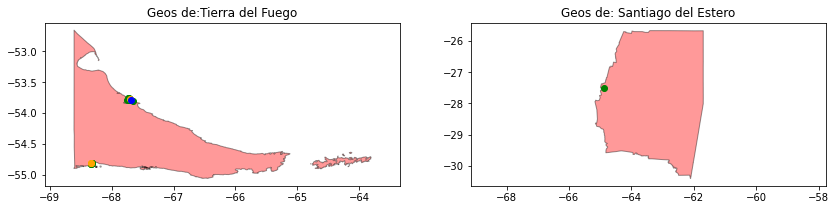

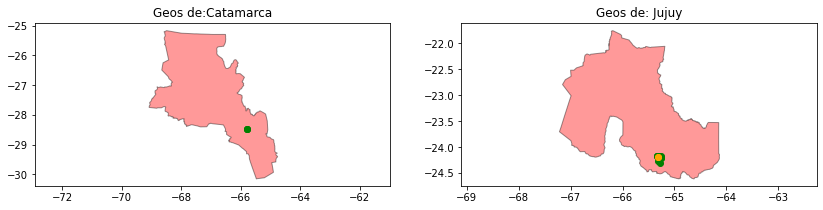

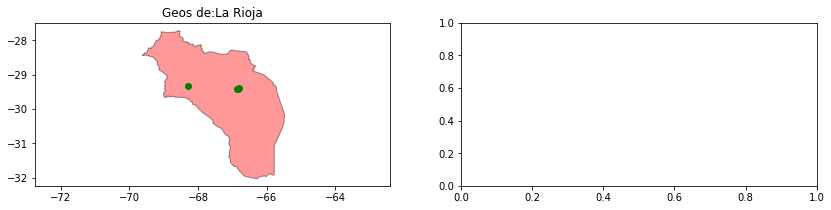

In [108]:
# podemos setear en no para evitar esta demora... # veremos cuales caen fuera
if correr == 'SI':
    for i in range(0,len(prov_names),2):
        fig = plt.figure(figsize=(14,3))
        try:
            ax1 = fig.add_subplot(1,2,1);         prov1 = i
            provincias.loc[provincias.provincia == prov_names[prov1]].plot(ax=ax1,alpha=0.4,color='red',edgecolor='black')
            orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 1)]
            if len(orig)>0:   orig.plot(ax=ax1,color='g')
            math = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 3)]
            if len(math)>0:   math.plot(ax=ax1,color='orange')
            move = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 2)]
            if len(move)>0:   move.plot(ax=ax1,color='b')
            plt.axis('equal'); ax1.set_title('Geos de:{}'.format(prov_names[prov1]));
        except:        break
        try:
            ax2 = fig.add_subplot(1,2,2);         prov2 = i+1
            provincias.loc[provincias.provincia == prov_names[prov2]].plot(ax=ax2,alpha=0.4,color='red',edgecolor='black')
            orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 1)]
            if len(orig)>0:   orig.plot(ax=ax2,color='g')
            math = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 3)]
            if len(math)>0:   math.plot(ax=ax2,color='orange')
            move = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 2)]
            if len(move)>0:   move.plot(ax=ax2,color='b')
            plt.axis('equal'); ax2.set_title('Geos de: {}'.format(prov_names[prov2]));
        except:        break

### vemos que los problematicos son los inventados
esto se debe al que el random centrado en la media quizás no caiga en el mapa

In [109]:
#intentamos con nuestro "pegador" de puntos... jaja

In [110]:
for i in range(len(prov_names)):
    prov = prov_names[i]
    puntos_prov = geodf_test.loc[geodf_test.state_name == prov]

    prov_map = provincias.loc[provincias.provincia == prov]
    prov_line = prov_lines.loc[prov_lines.provincia == prov].geometry.iloc[0]

    inside = list(gpd.sjoin(prov_map,puntos_prov,how='inner').index_right)
    puntos_in = puntos_prov.loc[inside]

    puntos_out = puntos_prov.loc[~puntos_prov.index.isin(inside)].copy()
    puntos_out.reset_index(drop=True,inplace=True)

    for x in range(len(puntos_out)):
        poly = prov_line
        point = puntos_out.loc[x].geometry

        d = poly.project(point)
        p = poly.interpolate(d)
        closest_coords = list(p.coords)[0]

        df.loc[puntos_out.index_df.iloc[x],'lat'] = Point(closest_coords).y
        df.loc[puntos_out.index_df.iloc[x],'lon'] = Point(closest_coords).x
        
        df.loc[puntos_out.index_df.iloc[x],'geo_ok'] = 2 # los puntos que movimos quedan en 2

In [111]:
set_geodf(df)

(120158, 'puntos.')

In [112]:
# comprobamos que todos hayan caido en su provincia
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires   ok
Buenos Aires                      ok
Entre Ríos                        ok
Santa Fe                          ok
Córdoba                           ok
Misiones                          ok
Salta                             ok
Neuquén                           ok
Río Negro                         ok
San Luis                          ok
Mendoza                           ok
Corrientes                        ok
Chubut                            ok
Tucumán                           ok
La Pampa                          ok
Chaco                             ok
San Juan                          ok
Santa Cruz                        ok
Tierra del Fuego                  ok
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [113]:
chequear()

# ahora si, todo ok...

In [114]:
tiempo()

'Desde el inicio, tardo en ejecutar: 3 minutos, 57 segundos.'

# solo faltan unas 1000
todas las obtenidas están en su provincia

In [115]:
len(df.loc[np.isnan(df.lat)])

1062

In [116]:
df.loc[np.isnan(df.lat)].geonames_id.unique()

array([3838609., 3845180., 3427506.,      nan, 3840902., 3864331.,
       3853958., 3845035., 3838715., 3430865., 3836188., 3852393.,
       3431204., 3435024., 3843919., 3431350., 3865991., 3839149.,
       3433821., 3427386., 3835883., 3866396., 3839406., 3843435.,
       3838865., 3861869., 3832679., 3864851., 3435974., 3834665.,
       3834450., 3433964., 3849574., 3836587., 3436030., 3838686.,
       3435704., 3427535., 3840293., 3865485., 3832603., 3859556.,
       3848299., 6690180., 3862286., 3861631., 3839441., 3427511.,
       3858677., 3834814., 3430311., 3435650., 3832733., 3430951.,
       6948895., 3837029., 3436058., 3856121., 3855072., 3835868.,
       3435406., 3840255., 3841462., 3837885., 3427689., 3836129.,
       3833675., 3845391., 3839303., 3846269., 3836586., 3433898.,
       3863596., 3860705., 3433325., 3845365., 3430759., 3837441.,
       3841678., 3433839., 3862546., 3832708., 3832800., 3855282.,
       3840300., 3842142., 3853352., 3854444., 3853404., 34352

# PARA_GEONAMES_start
encontramos varios errores en geoNames, por lo que será el ultimo recurso

In [117]:
# volvemos a acortar el df con lo que necesitamos buscar
para_geonames=df.loc[np.isnan(df.lat) & ~np.isnan(df.geonames_id)]\
[['place_name','parent_names','state_name','geonames_id','lat','lon','id','geo_ok']]

para_geonames.reset_index(inplace=True)

para_geonames.columns=['index_df','place_name','parent_names','state_name','geonames_id','lat','lon','id','geo_ok']
para_geonames.sample(3)

,index_df,place_name,parent_names,state_name,geonames_id,lat,lon,id,geo_ok
851,107934,Cushamen,Chubut|Cushamen,Chubut,3859556.0,NaN,NaN,1bz2o,0
61,8688,Roosevelt,Buenos Aires|Rivadavia|Roosevelt,Buenos Aires,3838609.0,NaN,NaN,161st,0
816,106631,Luque,Córdoba|Luque,Córdoba,3845365.0,NaN,NaN,1bwn9,0


In [118]:
para_geonames.geonames_id = para_geonames.geonames_id.astype(int)

In [119]:
len(para_geonames)

916

# geonames_id database
encontramos en el dataset una columna de geonames_id, el sitio web https://www.geonames.org/ conseguimos un dataset que nos pasa estas coordenadas, si bien no será la locacion exacta de la propiedad nos dará información del "barrio/zona" donde se encuentra

In [120]:
# preparamos los nombres de las columnas segun la documentacion
names = ['geonameid','name','asciiname','alternatenames','latitude','longitude','feature_class','feature_code','country_code','cc2','admin1_code','admin2_code','admin3_code','admin4_code','population','elevation','dem','timezone','modification_date']
# leemos el dataframe
geoNames = pd.read_csv('carto/geonames_id/AR/AR_copia.csv',error_bad_lines=False,sep=';',header=None,names=names)

geoNames = geoNames[['geonameid', 'name', 'asciiname', 'latitude','longitude','admin1_code', ]]

geoNames.admin1_code = geoNames.admin1_code.astype(float)
geoNames.sample(2)

,geonameid,name,asciiname,latitude,longitude,admin1_code
16901,3839566,Laguna de Quimilar,Laguna de Quimilar,-29.20368,-64.17833,22.0
14357,3837012,Estancia San Marcos,Estancia San Marcos,-37.00312,-64.52698,11.0


In [121]:
names = ['code','name','asciiname','geonameid']
admin1 = pd.read_csv('carto/geonames_id/admin1CodesASCII.csv',error_bad_lines=False,sep='|',header=None,names = names)

admin1['pais'] = [admin1.code.iloc[i].split('.')[0] for i in range(len(admin1))]
admin1['prov_cod'] = [admin1.code.iloc[i].split('.')[1] for i in range(len(admin1))]
cod_admin1 = admin1.loc[admin1.pais == 'AR'].copy()
cod_admin1.reset_index(inplace=True,drop=True)
cod_admin1['name'] = cod_admin1.name.str.replace('Cordoba','Córdoba').replace('Rio Negro','Río Negro').replace('Tucuman','Tucumán').replace('Entre Rios','Entre Ríos').replace('Neuquen','Neuquén').replace('Buenos Aires F.D.','Ciudad Autónoma de Buenos Aires')
cod_admin1['prov_cod'] = cod_admin1.prov_cod.astype(float)

cod_admin_dic = {cod_admin1.prov_cod.iloc[i] : cod_admin1.name.iloc[i] for i in range(len(cod_admin1))}

In [122]:
geoNames['state_name'] = geoNames.admin1_code.map(cod_admin_dic)

geoNames = geoNames.dropna(subset=['state_name'])

geoNames.reset_index(inplace=True,drop=True)
geoNames.reset_index(inplace=True)

# ponemos ahi el index_df para que nos funcionen las funciones, ja!
geoNames.columns = ['index_df', 'geonameid', 'name', 'asciiname', 'latitude', 'longitude', 'admin1_code', 'state_name']

geoNames.sample(4)

,index_df,geonameid,name,asciiname,latitude,longitude,admin1_code,state_name
19505,19505,3842404,Paganzo,Paganzo,-30.20732,-67.28416,12.0,La Rioja
4497,4497,3431733,Estancia Las Magnolias,Estancia Las Magnolias,-32.26635,-59.12465,8.0,Entre Ríos
27417,27417,3850424,La Lechuza,La Lechuza,-30.90000,-63.93333,5.0,Córdoba
43075,43075,3866383,Aldea Nueva,Aldea Nueva,-31.88343,-60.23474,8.0,Entre Ríos


In [123]:
set_geodf(geoNames)

(48640, 'puntos.')

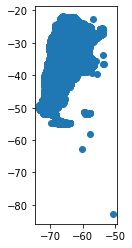

In [124]:
# aqui vemos muchos errores, ni hablar entre provincias
geodf_test.plot()

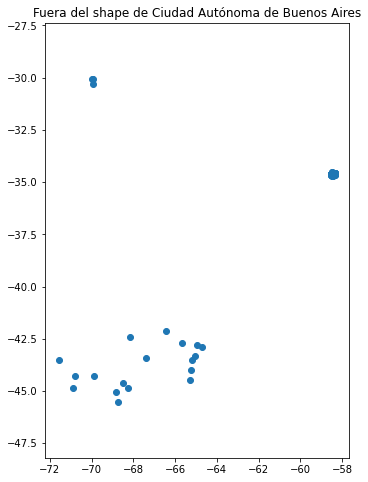

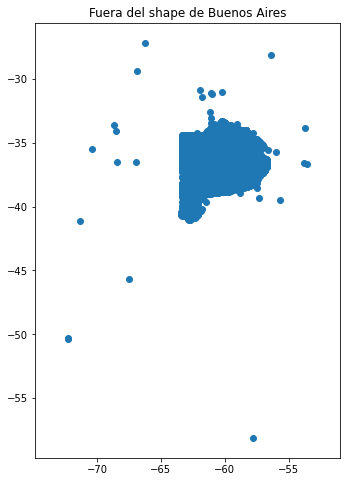

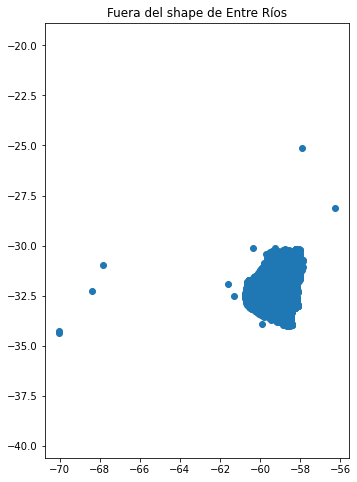

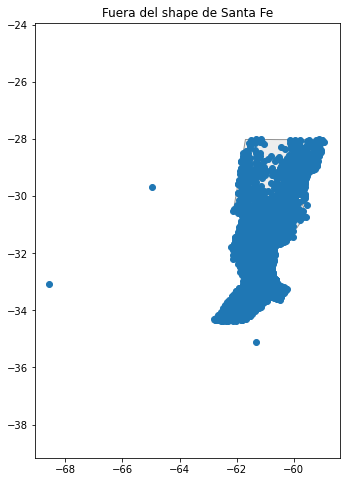

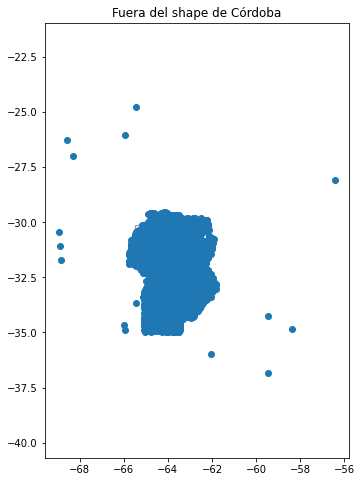

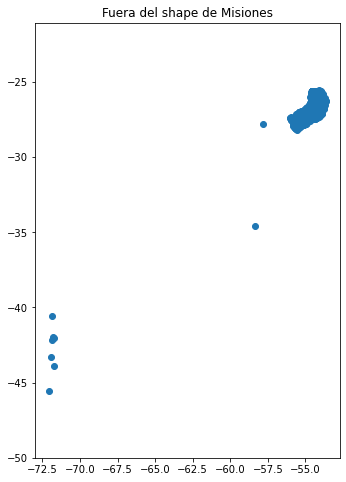

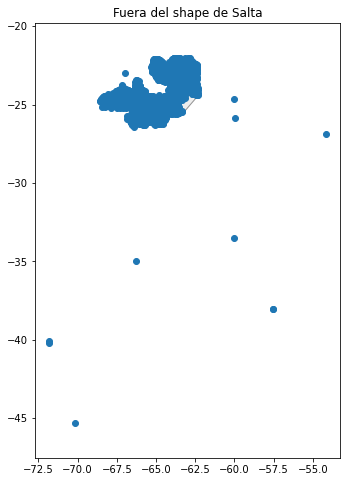

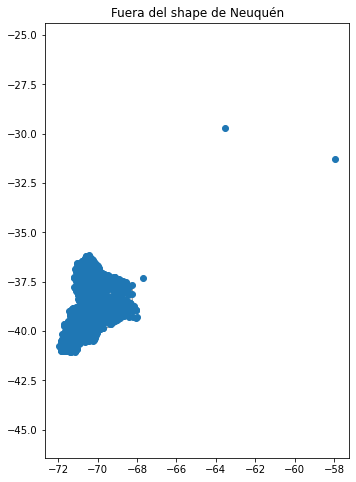

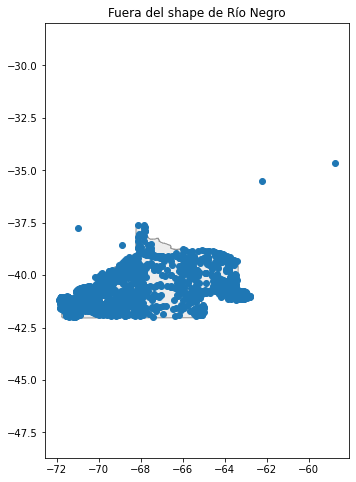

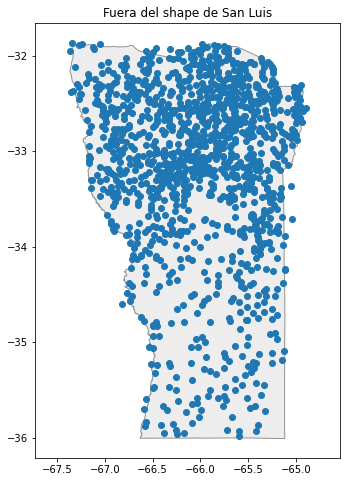

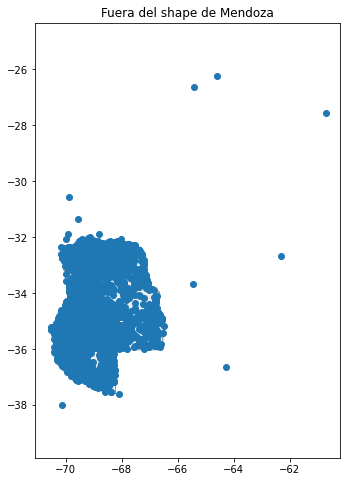

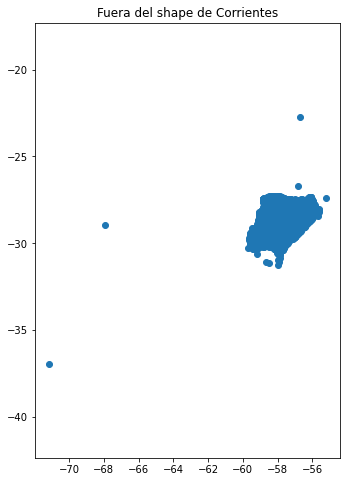

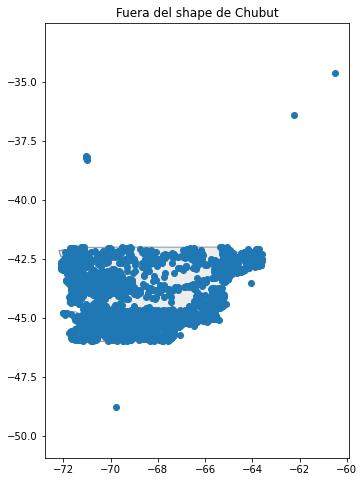

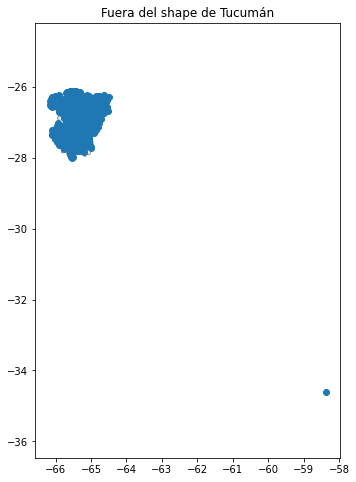

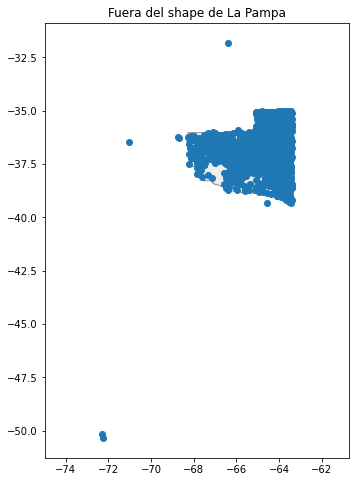

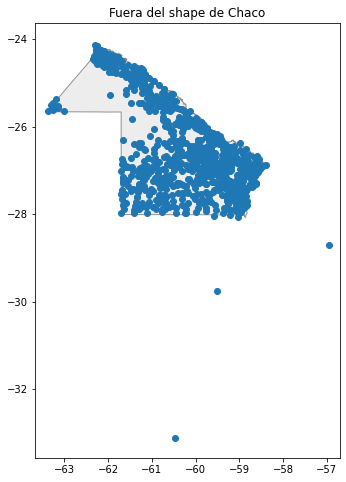

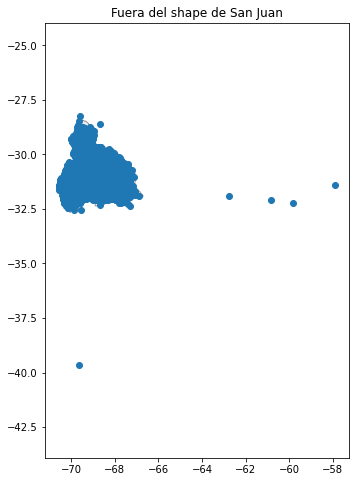

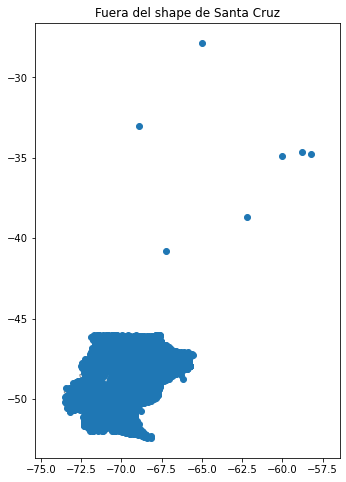

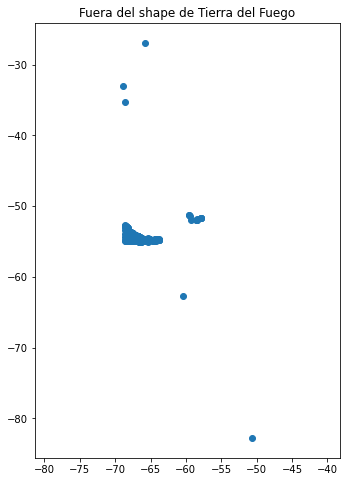

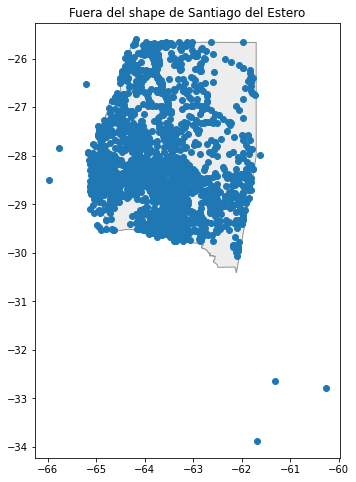

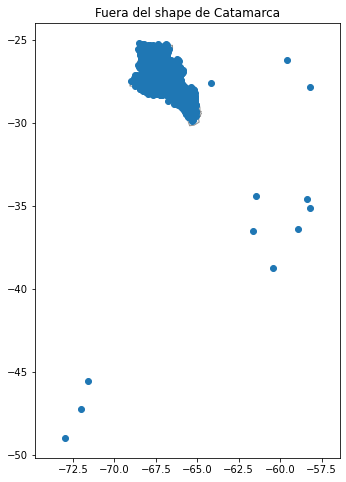

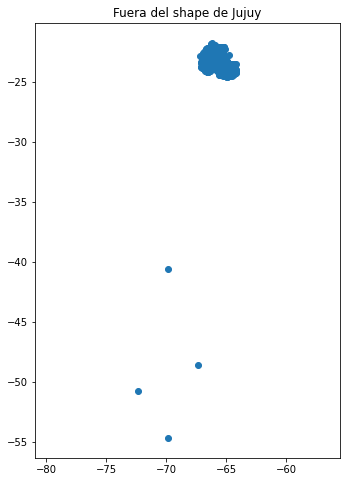

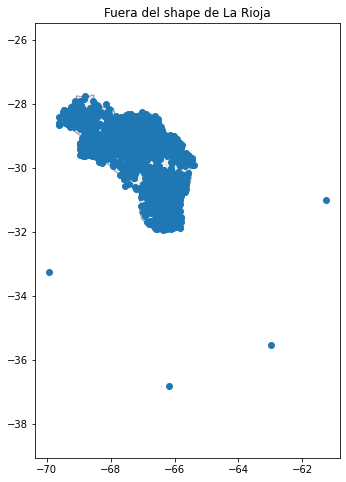

In [125]:
# vamos a dropear todo este ruido
if correr=='SI':
    for i in range(len(prov_names)):
        ver_prov(prov_names[i])

In [126]:
# ninguna coincide 100%....
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires
Buenos Aires
Entre Ríos
Santa Fe
Córdoba
Misiones
Salta
Neuquén
Río Negro
San Luis
Mendoza
Corrientes
Chubut
Tucumán
La Pampa
Chaco
San Juan
Santa Cruz
Tierra del Fuego
Santiago del Estero
Catamarca
Jujuy
La Rioja


### con este loop reseteamos los puntos fuera del hull de cada provincia
hay que chequear las columnas y donde borra el resultado

In [127]:
geoNames.shape

(48640, 10)

[0, 'Ciudad Autónoma de Buenos Aires', 41, 'reseteados']
[1, 'Buenos Aires', 301, 'reseteados']
[2, 'Entre Ríos', 134, 'reseteados']
[3, 'Santa Fe', 17, 'reseteados']
[4, 'Córdoba', 48, 'reseteados']
[5, 'Misiones', 44, 'reseteados']
[6, 'Salta', 57, 'reseteados']
[7, 'Neuquén', 39, 'reseteados']
[8, 'Río Negro', 30, 'reseteados']
[9, 'San Luis', 38, 'reseteados']
[10, 'Mendoza', 72, 'reseteados']
[11, 'Corrientes', 26, 'reseteados']
[12, 'Chubut', 207, 'reseteados']
[13, 'Tucumán', 19, 'reseteados']
[14, 'La Pampa', 16, 'reseteados']
[15, 'Chaco', 15, 'reseteados']
[16, 'San Juan', 37, 'reseteados']
[17, 'Santa Cruz', 169, 'reseteados']
[18, 'Tierra del Fuego', 157, 'reseteados']
[19, 'Santiago del Estero', 52, 'reseteados']
[20, 'Catamarca', 36, 'reseteados']
[21, 'Jujuy', 40, 'reseteados']
[22, 'La Rioja', 67, 'reseteados']


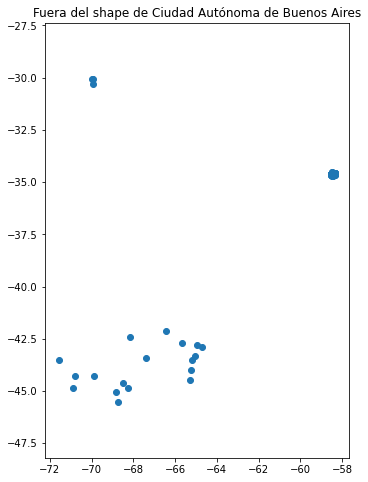

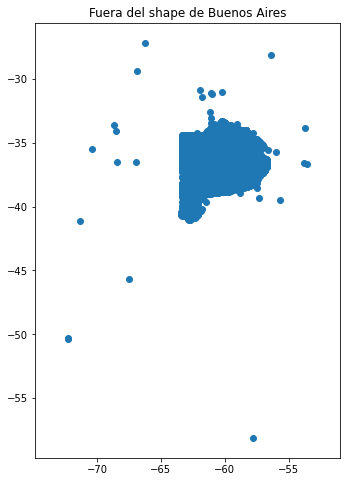

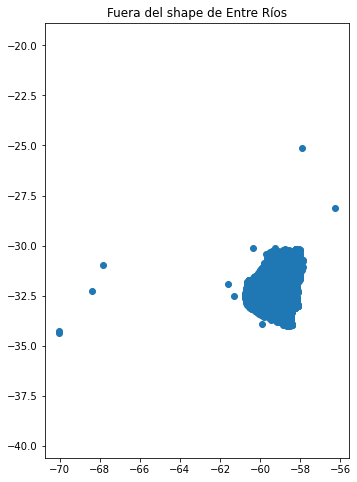

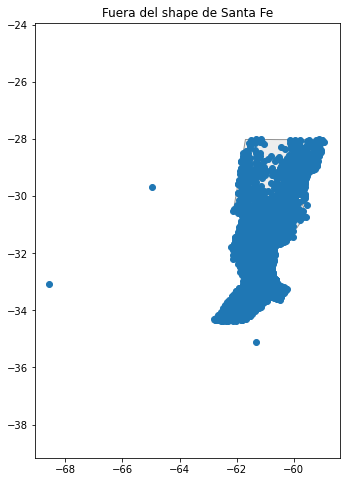

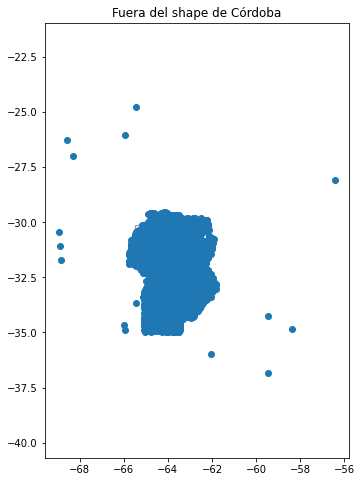

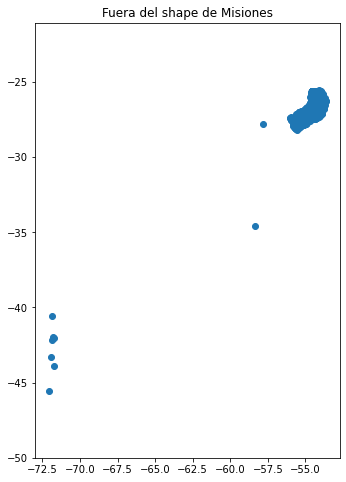

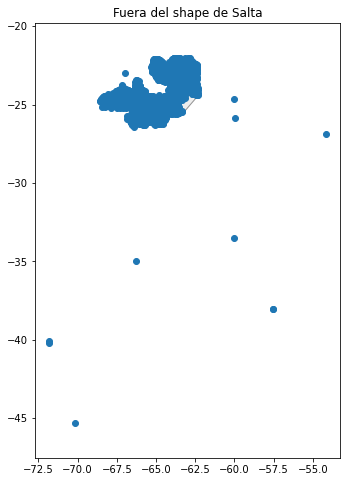

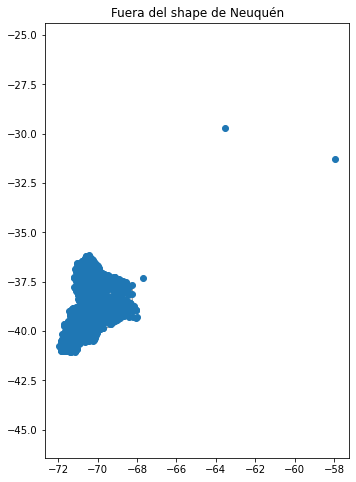

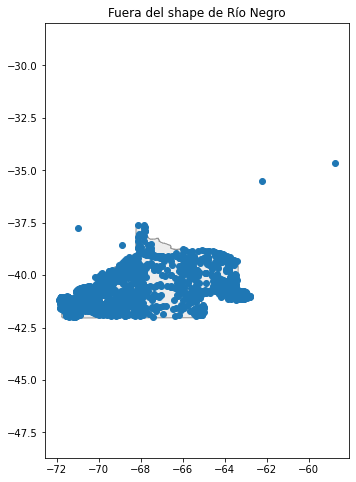

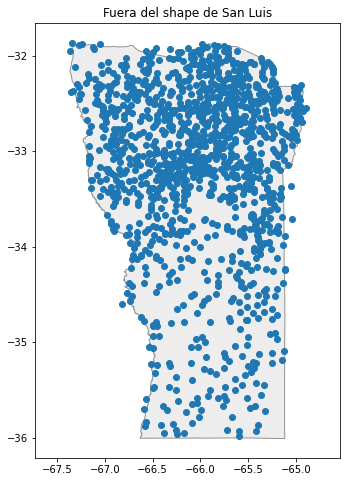

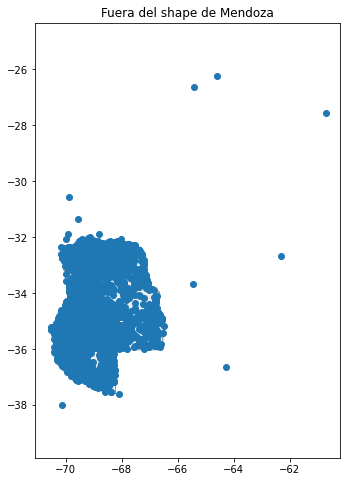

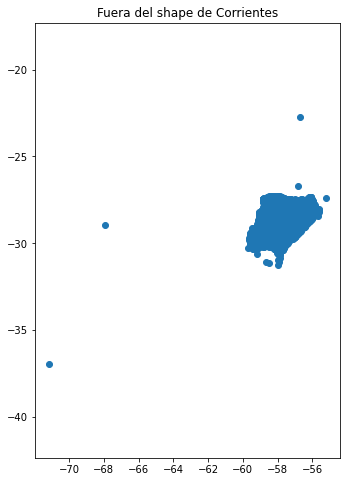

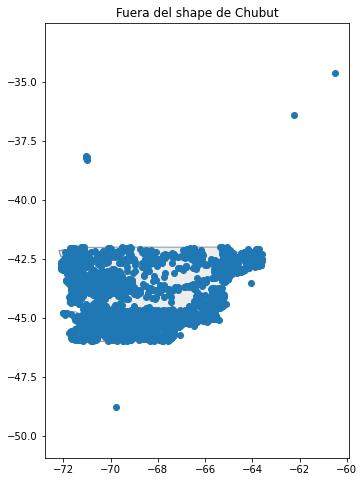

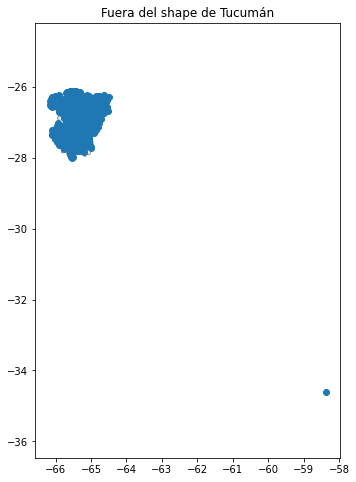

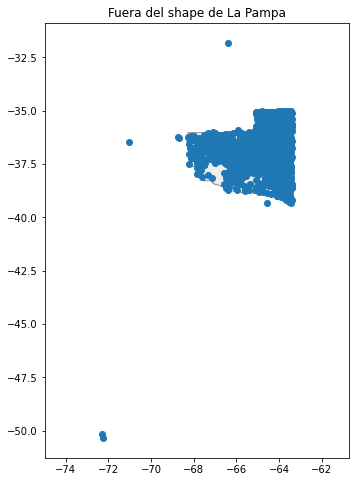

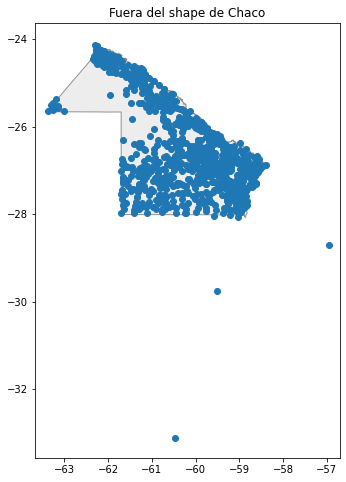

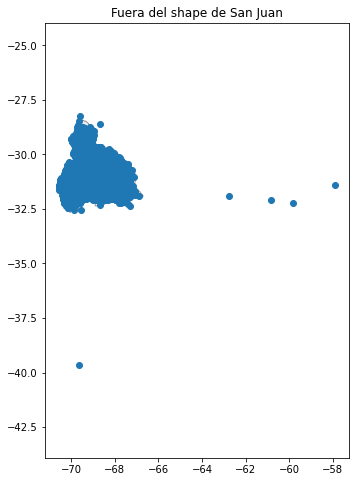

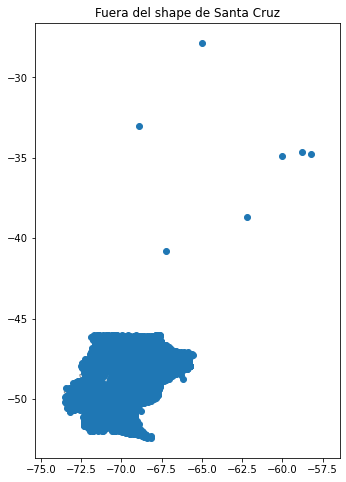

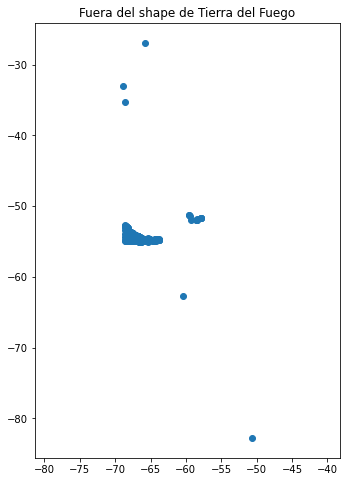

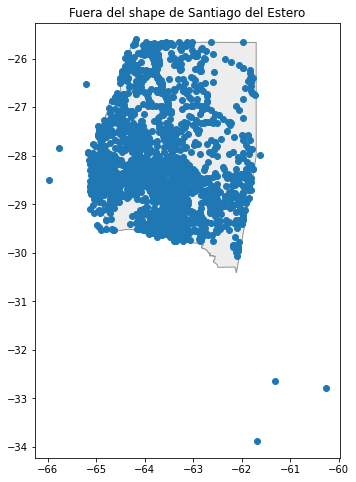

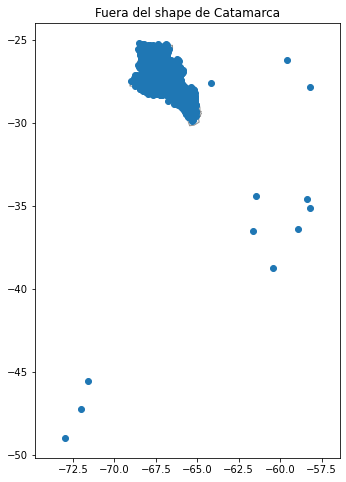

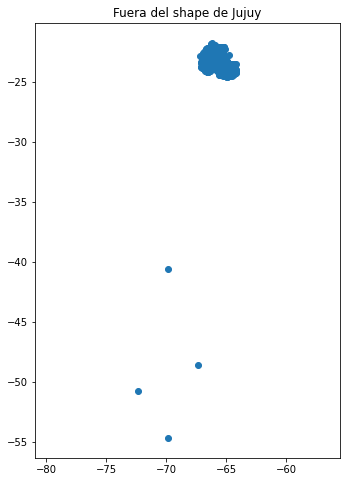

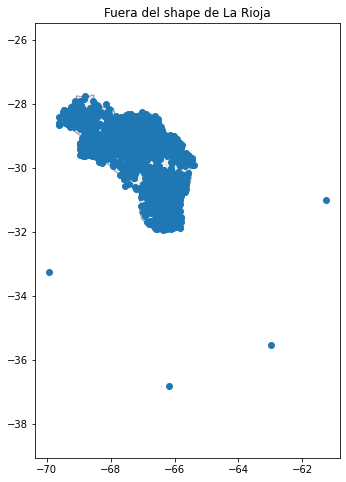

In [128]:
puntos_reseteados = [] # en este caso eliminamos todo lo que no caiga dentro de la provincia...

for i in range(len(prov_names)):
    # establecemos la provincia
    id_prov = prov_names[i]

    # nos guardamos los puntos correspondientes a la provincia
    puntos = geodf_test.loc[geodf_test.state_name == id_prov]
    puntos.reset_index(drop=True,inplace=True)
    puntos.columns = ['index', 'index_df', 'geonameid', 'name', 'asciiname', 'latitude', 'longitude', 'admin1_code', 'state_name', 'geometry']
    # nos guardamos el mapa de la provincia
    provincia = provincias.loc[provincias.provincia == id_prov]

    # verificamos que puntos se superponen con el shape de la provincia
    inside = gpd.sjoin(provincia,puntos,how='inner')
    inside.reset_index(drop=True,inplace=True)
    
    # nos guardamos los puntos que no se superponen
    puntos_fuera = puntos.loc[~(puntos.index_df.isin(inside.index_df))]
    
    if len(puntos_fuera) > 0:
        print([i,id_prov,len(puntos)-len(inside),'reseteados'])
        if mapas == 'SI':
            ver_prov(id_prov)

    # finalmente reseteamos lat-lon en df
    
    geoNames.loc[list(puntos_fuera['index_df']),'latitude'] = np.nan
    geoNames.loc[list(puntos_fuera['index_df']),'longitude'] = np.nan


In [129]:
print(len(geoNames.loc[np.isnan(geoNames.latitude)]),'reseteados')

1662 reseteados


In [130]:
geoNames = geoNames.loc[~np.isnan(geoNames.latitude)]
geoNames.reset_index(drop=True,inplace=True)

In [131]:
set_geodf(geoNames)

(46978, 'puntos.')

In [132]:
# ahora si, podemos usar estas geometrias con tranquilidad
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires   ok
Buenos Aires                      ok
Entre Ríos                        ok
Santa Fe                          ok
Córdoba                           ok
Misiones                          ok
Salta                             ok
Neuquén                           ok
Río Negro                         ok
San Luis                          ok
Mendoza                           ok
Corrientes                        ok
Chubut                            ok
Tucumán                           ok
La Pampa                          ok
Chaco                             ok
San Juan                          ok
Santa Cruz                        ok
Tierra del Fuego                  ok
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [133]:
chequear()

In [134]:
tiempo()

'Desde el inicio, tardo en ejecutar: 4 minutos, 30 segundos.'

# podemos pisar informacion segun geoname_id

In [135]:
len(df.loc[np.isnan(df.lat)])

1062

In [136]:
# acortamos el nombre para facilitar el codigo
gn = geoNames.copy()

# creamos un dic con los resultados
geonames_dic = {gn.geonameid.iloc[i]:[gn.latitude.iloc[i],gn.longitude.iloc[i]] for i in range(len(gn))}

# creamos una lista con los existentes
hay_geoid = list(df.loc[(df.geo_ok == 0) & ~(np.isnan(df.geonames_id))].geonames_id.unique())

In [137]:
geonames_dic[hay_geoid[0]]

[-35.84786, -63.292759999999994]

In [138]:
for i in range(len(hay_geoid)):

    df.loc[(np.isnan(df.lat))&(df.geonames_id == hay_geoid[i]),'lat'] = float(str(geonames_dic[hay_geoid[i]][0])[:10])
    df.loc[(np.isnan(df.lon))&(df.geonames_id == hay_geoid[i]),'lon'] = float(str(geonames_dic[hay_geoid[i]][1])[:10])
    df.loc[(df.geo_ok == 0)&(df.geonames_id == hay_geoid[i]),'geo_ok'] = 4     # para los conseguidos de geoNames

### checking

In [139]:
len(df.loc[np.isnan(df.lat)])

146

In [140]:
set_geodf(df)

(121074, 'puntos.')

In [141]:
loop_check(geodf_test)

Ciudad Autónoma de Buenos Aires   ok
Buenos Aires                      ok
Entre Ríos                        ok
Santa Fe                          ok
Córdoba                           ok
Misiones                          ok
Salta                             ok
Neuquén                           ok
Río Negro                         ok
San Luis                          ok
Mendoza                           ok
Corrientes                        ok
Chubut                            ok
Tucumán                           ok
La Pampa                          ok
Chaco                             ok
San Juan                          ok
Santa Cruz                        ok
Tierra del Fuego                  ok
Santiago del Estero               ok
Catamarca                         ok
Jujuy                             ok
La Rioja                          ok


In [142]:
chequear()

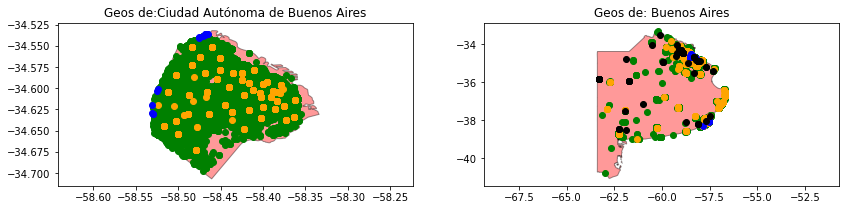

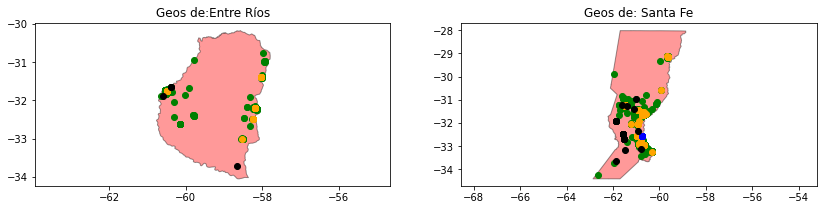

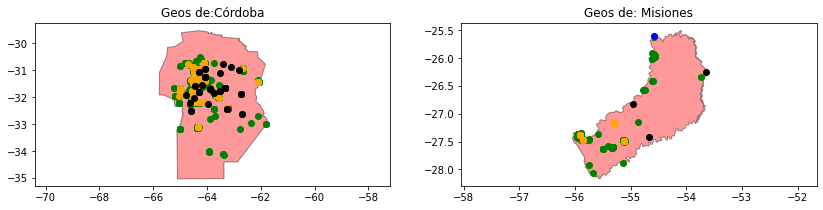

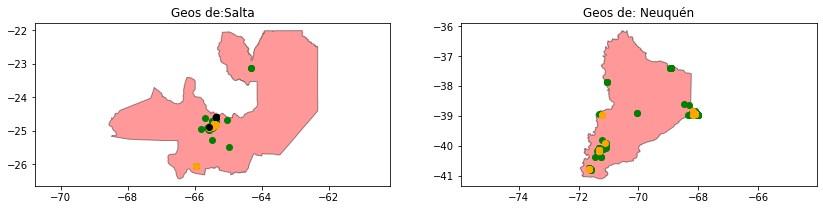

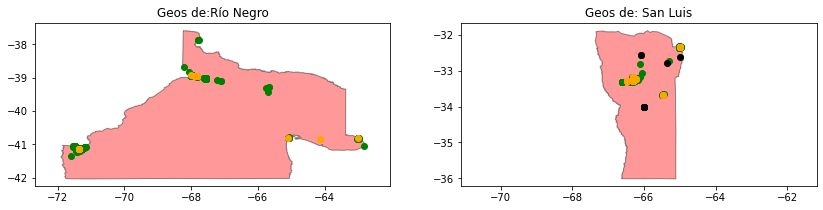

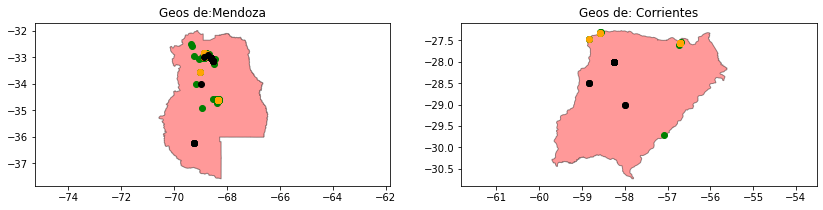

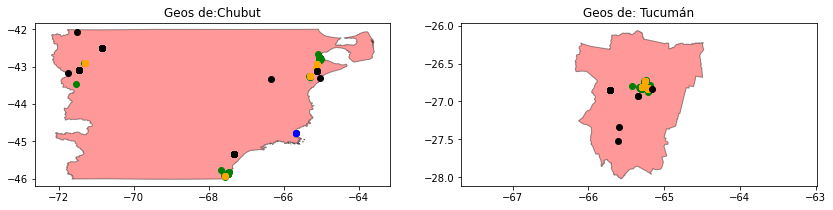

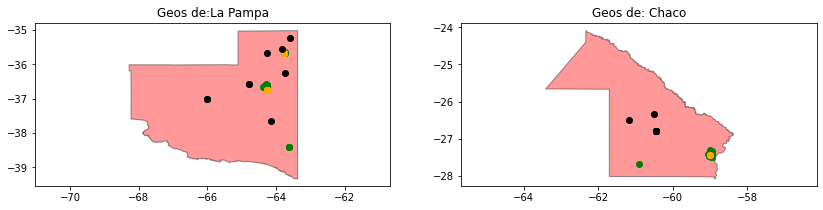

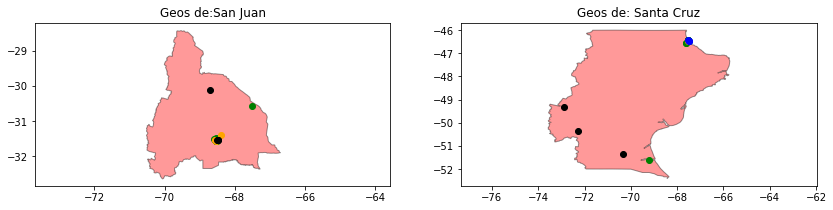

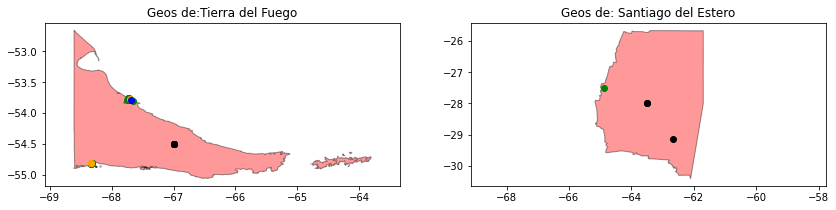

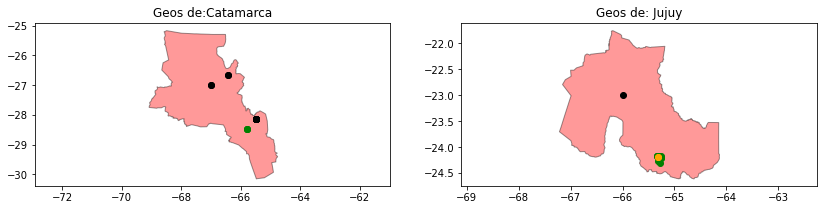

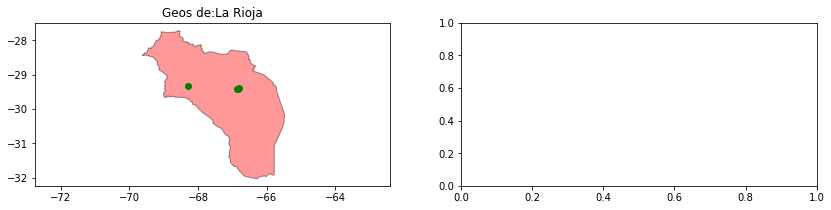

In [143]:
# podemos setear en no para evitar esta demora... # veremos cuales caen fuera
if correr=='SI':
    for i in range(0,len(prov_names),2):
        fig = plt.figure(figsize=(14,3))
        try:
            ax1 = fig.add_subplot(1,2,1);         prov1 = i
            provincias.loc[provincias.provincia == prov_names[prov1]].plot(ax=ax1,alpha=0.4,color='red',edgecolor='black')
            orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 1)]
            if len(orig)>0:   orig.plot(ax=ax1,color='g')
            math = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 3)]
            if len(math)>0:   math.plot(ax=ax1,color='orange')
            move = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 2)]
            if len(move)>0:   move.plot(ax=ax1,color='b')
            geoi = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 4)]
            if len(geoi)>0:   geoi.plot(ax=ax1,color='k')


            plt.axis('equal'); ax1.set_title('Geos de:{}'.format(prov_names[prov1]));
        except:        break
        try:
            ax2 = fig.add_subplot(1,2,2);         prov2 = i+1
            provincias.loc[provincias.provincia == prov_names[prov2]].plot(ax=ax2,alpha=0.4,color='red',edgecolor='black')
            orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 1)]
            if len(orig)>0:   orig.plot(ax=ax2,color='g')
            math = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 3)]
            if len(math)>0:   math.plot(ax=ax2,color='orange')
            move = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 2)]
            if len(move)>0:   move.plot(ax=ax2,color='b')
            geoi = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 4)]
            if len(geoi)>0:   geoi.plot(ax=ax2,color='k')            

            plt.axis('equal'); ax2.set_title('Geos de: {}'.format(prov_names[prov2]));
        except:        break

# JOYA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [144]:
tiempo()

'Desde el inicio, tardo en ejecutar: 5 minutos, 1 segundos.'

# solo quedan 146 volvemos a comprobar via googlemaps

In [145]:
len(df.loc[df.geo_ok == 0])

146

In [146]:
# son solo 64 lugares, los buscamos en maps....
len(df.loc[df.geo_ok == 0].parent_names.unique())

64

In [147]:
ver = 'Entre Ríos|Alejandro Roca'
print(df.loc[df.parent_names == ver].description.iloc[0])
df.loc[df.parent_names == ver]

 .Publicado por Avalon propiedades a traves INMOMAP


,operation,property_type,place_name,parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,id,geo_ok
26831,sell,house,Alejandro Roca,Entre Ríos|Alejandro Roca,Argentina,Entre Ríos,NaN,NaN,NaN,NaN,...,39062.5,NaN,1.0,NaN,http://www.properati.com.ar/17rk2_venta_casa_a...,.Publicado por Avalon propiedades a traves IN...,casa,NaN,17rk2,0


In [148]:
ultimos = {
    'Buenos Aires|Berazategui|Sourigues':     [-34.8017325,-58.2281667], 'Buenos Aires|Ituzaingó|El Casco de Leloir':  [-34.6195785,-58.6895265], 'San Juan|Desamparados':                          [-31.5280373,-68.5748551], 'Buenos Aires|José C Paz|Tortuguitas': [-34.47605,-58.764378],    'Buenos Aires|Mar del Plata|Puerto':        [-38.0471808,-57.5458097], 'Buenos Aires|Mar del Plata|Materno':            [-38.0035738,-57.5497047], 'Buenos Aires|General Pueyrredón|Laguna de los Padres': [-37.935015,-57.744285],   'Buenos Aires|Mar del Plata|Bosque Peralta Ramos': [-38.0761585,-57.566101],  'Buenos Aires|La Plata|Grand Bell':          [-34.9058175,-58.0734153], 'Entre Ríos|Costa Uruguay Sur':     [-33.0447535,-58.2621437],    'Buenos Aires|Exaltación de la Cruz|El Remanso': [-34.3910162,-59.085044],    'Catamarca|Agua Blanca': [-28.4692931,-65.7852717],    'Santa Fe|Desvío Arijón': [-31.8791021,-60.892074],    'Buenos Aires|Azul|Azul': [-36.7757613,-59.8563491],    'Córdoba|Cabalango': [-31.3909272,-64.5595919],    'Buenos Aires|Lomas de Zamora|Villa Fiorito': [-34.7074316,-58.4440586],    'Buenos Aires|Mar del Plata|Plaza Rocha': [-37.9765027,-57.5493988],    'Entre Ríos|Alejandro Roca': [-31.7719944,-60.4742567],
    'Buenos Aires|Campana|Alto Los Cardales': [-34.3138014,-58.9759327], 'Buenos Aires|San Miguel|San Miguel de Ghiso':[-34.5711497,-58.7081846], 'Buenos Aires|San Vicente|Fincas de San Vicente': [-35.0293309,-58.4519907], 'Buenos Aires|Pilar|La Agustina':      [-34.4637338,-58.8878297], 'Buenos Aires|Pilar|Princess':              [-34.4331142,-58.7822887], 'Buenos Aires|Pilar|El Molino':                  [-34.4362249,-58.8404535], 'Buenos Aires|Pilar|El Zorzal':                         [-34.4491889,-58.9243992], 'Buenos Aires|Escobar|San Lucas Village':          [-34.4002746,-58.7447757], 'Catamarca|La Falda':                        [-28.7724563,-65.4682651],  'Buenos Aires|Mar del Plata|Alfar': [-37.9641834,-57.6490833],    'Buenos Aires|Mar Chiquita|La Caleta': [-37.7784681,-57.4686108],    'Buenos Aires|Mar del Plata|Barrio Fortunato de La Plaza': [-38.0372844,-57.5837245],    'Buenos Aires|Tigre|Benavidez Greens': [-34.4231398,-58.7120818],    'Buenos Aires|Escobar|Rincón de Maschwitz': [-34.3943309,-58.7279528],    'Buenos Aires|Escobar|Los Robles de Maschwitz': [-34.3880379,-58.7680062],    'Buenos Aires|Tigre|Villa Bertha': [-34.405814,-58.7081992],    'Buenos Aires|Tigre|Rincón de la Costa': [-34.4090408,-58.6180559],
    'Buenos Aires|J A de la Peña|Pergamino':  [-33.8317366,-60.4924946], 'Buenos Aires|San Fernando|Rincon Del Arca':  [-34.4424441,-58.5426917], 'Buenos Aires|José C Paz|Golf Club Argentino':    [-34.4728543,-58.7938809], 'Buenos Aires|Pilar|La Herradura':     [-34.4434235,-58.834095],  'Buenos Aires|Mar del Plata|Punta Iglesia': [-37.9969901,-57.546878],  'Buenos Aires|Esteban Echeverría|El Centauro':   [-34.8619364,-58.5004954], 'Buenos Aires|Mar del Plata|Playa Serena':              [-38.1051992,-57.584591],  'Buenos Aires|Esteban Echeverría|9 de Abril':      [-34.7595467,-58.4922262], 'Buenos Aires|Esteban Echeverría|Brickland': [-34.8682617,-58.4782324], 'Buenos Aires|Pilar|La Pilarica':   [-34.4503353,-58.8395567],    'Buenos Aires|Luján|Santa Catalina': [-34.4675063,-59.0662042],    'Buenos Aires|San Isidro|Virasoro Village': [-34.4821889,-58.5655416],    'Buenos Aires|Esteban Echeverría|Mi Refugio': [-34.8754013,-58.4720965],    'Buenos Aires|Ezeiza|Terralagos': [-34.9070276,-58.5168307],    'Buenos Aires|General San Martín|Villa Granaderos De San Martin': [-34.5449993,-58.5397111],    'Santa Fe|Los Laureles': [-31.5091917,-60.398308],    'Entre Ríos|Santa Luisa': [-31.8616337,-60.4217926],
    'Buenos Aires|San Fernando|Bahía del Sol':[-34.4421777,-58.5446659], 'Buenos Aires|Junín|Junín':                   [-34.5902482,-60.9513427], 'Buenos Aires|San Fernando|Punta Chica Village':  [-34.4514113,-58.5260286], 'Buenos Aires|Tigre|Hindu Club':       [-34.4978766,-58.6472807], 'Buenos Aires|Tigre|El Viejo Vivero':       [-34.503094,-58.6353801],  'Buenos Aires|Lomas de Zamora|Villa Centenario': [-34.7313048,-58.4264366], 'Buenos Aires|San Isidro|San Isidro Chico':             [-34.4590322,-58.5156647], 'Santa Fe|Arroyo Ceibal':                          [-28.7211401,-59.4853177], 'Córdoba|La Serranita':                      [-31.7367292,-64.4583945], 'Córdoba|Mayu Sumaj':               [-31.4740148,-64.5430165],    'Córdoba|Mi Granja': [-31.3433245,-64.0088256],    'Buenos Aires|Berazategui|Altos de Hudson I' : [-34.8025589,-58.1708372]    }

In [149]:
faltan_parent = list(df.loc[(df.geo_ok == 0)].parent_names.unique())

In [150]:
for i in range(len(faltan_parent)):

    df.loc[(np.isnan(df.lat))&(df.parent_names == faltan_parent[i]),'lat'] = float(str(ultimos[faltan_parent[i]][0])[:10])
    df.loc[(np.isnan(df.lon))&(df.parent_names == faltan_parent[i]),'lon'] = float(str(ultimos[faltan_parent[i]][1])[:10])
    df.loc[(df.geo_ok == 0)&(df.parent_names == faltan_parent[i]),'geo_ok'] = 5     # para los conseguidos de geoNames

In [151]:
df.geo_ok.unique()

array([1, 3, 4, 2, 5], dtype=int64)

# LISTO, TODO COMPLETO

In [152]:
set_geodf(df)

(121220, 'puntos.')

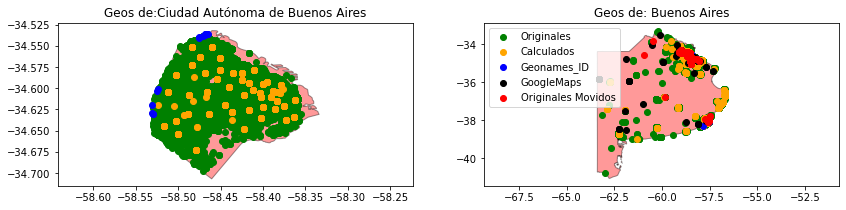

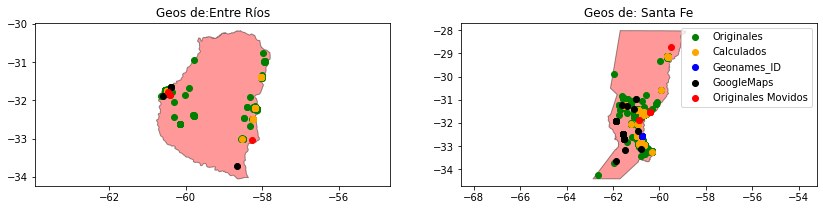

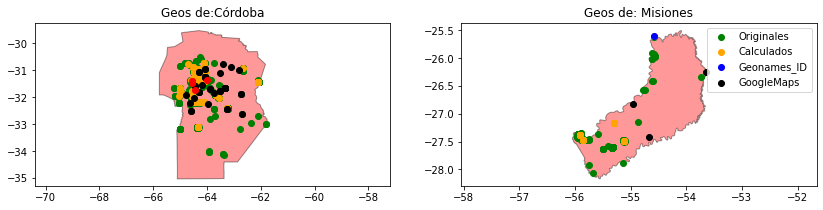

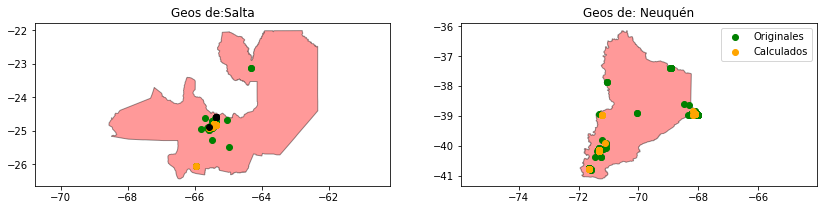

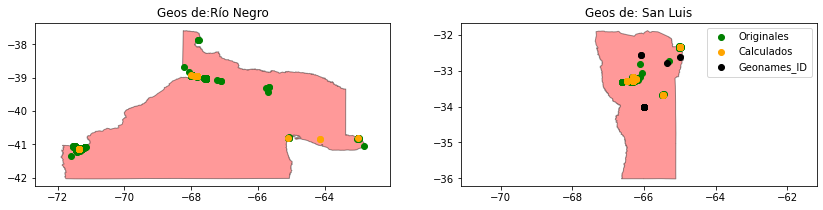

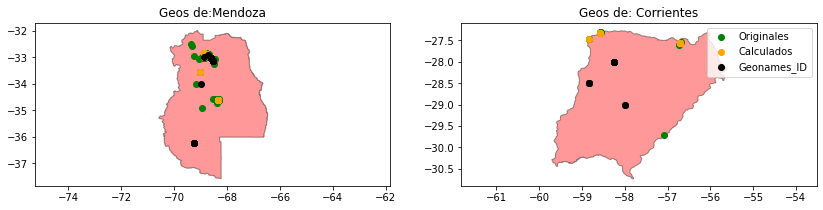

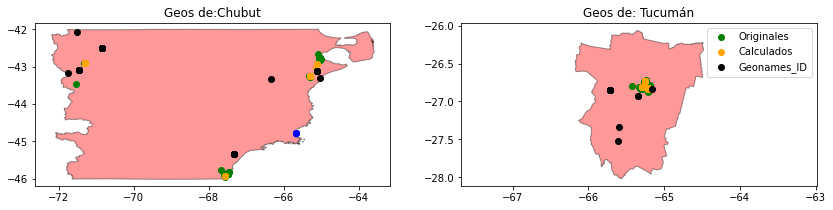

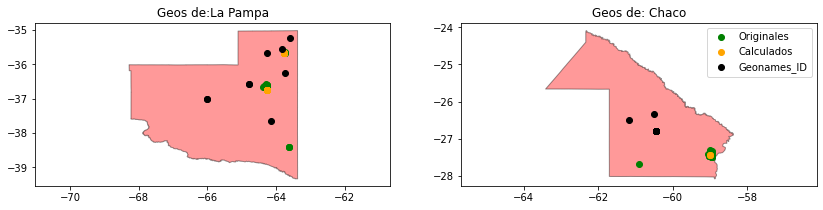

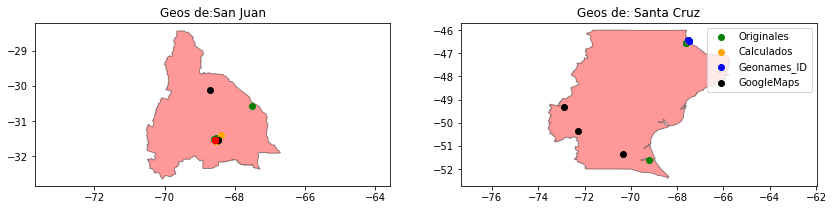

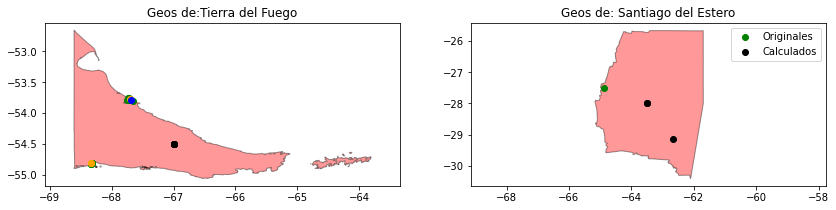

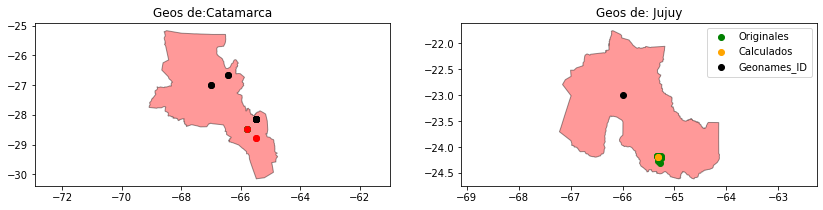

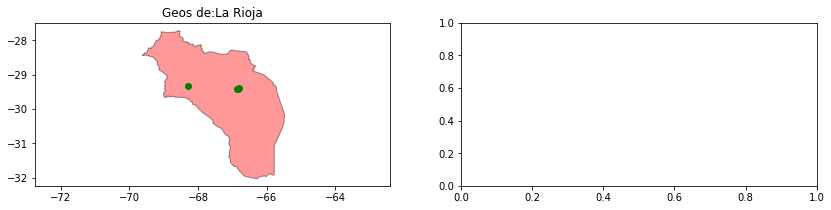

In [153]:
# podemos setear en no para evitar esta demora... # veremos cuales caen fuera
for i in range(0,len(prov_names),2):
    fig = plt.figure(figsize=(14,3))
    try:
        ax1 = fig.add_subplot(1,2,1);         prov1 = i
        provincias.loc[provincias.provincia == prov_names[prov1]].plot(ax=ax1,alpha=0.4,color='red',edgecolor='black')
        orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 1)]
        if len(orig)>0:   orig.plot(ax=ax1,color='g')
        math = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 3)]
        if len(math)>0:   math.plot(ax=ax1,color='orange')
        move = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 2)]
        if len(move)>0:   move.plot(ax=ax1,color='b')
        geoi = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 4)]
        if len(geoi)>0:   geoi.plot(ax=ax1,color='k')
        geoG = geodf_test.loc[(geodf_test.state_name == prov_names[prov1]) & (geodf_test.geo_ok == 5)]
        if len(geoG)>0:   geoG.plot(ax=ax1,color='r')

        plt.axis('equal'); ax1.set_title('Geos de:{}'.format(prov_names[prov1]));
    except:        break
    try:
        ax2 = fig.add_subplot(1,2,2);         prov2 = i+1
        provincias.loc[provincias.provincia == prov_names[prov2]].plot(ax=ax2,alpha=0.4,color='red',edgecolor='black')
        orig = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 1)]
        if len(orig)>0:   orig.plot(ax=ax2,color='g')
        math = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 3)]
        if len(math)>0:   math.plot(ax=ax2,color='orange')
        move = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 2)]
        if len(move)>0:   move.plot(ax=ax2,color='b')
        geoi = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 4)]
        if len(geoi)>0:   geoi.plot(ax=ax2,color='k')
        geoG = geodf_test.loc[(geodf_test.state_name == prov_names[prov2]) & (geodf_test.geo_ok == 5)]
        if len(geoG)>0:   geoG.plot(ax=ax2,color='r')
        plt.legend({'Originales' : '','Calculados' : '','Geonames_ID' : '','GoogleMaps' : '','Originales Movidos' : ''})

        plt.axis('equal'); ax2.set_title('Geos de: {}'.format(prov_names[prov2]));
    except:        break

In [154]:
# ya es definitivo y correcto, lo renombramos y con él trabajaremos
geodf = geodf_test.copy()

In [155]:
geodf.shape

(121220, 7)

In [156]:
df.shape

(121220, 27)

In [157]:
geodf = geodf[['index_df', 'place_name', 'state_name','geo_ok','geometry']]

# ya tenemos todas las geolocalizaciones

In [158]:
# exportamos el shape con las coordenadas depuradas
geodf.to_file('properati_geoshape/geo_properatti.shp')

In [158]:
tiempo()

'Desde el inicio, tardo en ejecutar: 5 minutos, 34 segundos.'

# fin!

# gentes!

aca les dejo como levantar el archivo geo_properatti.shp (shape), el index coincide y está ordenado segun el df original, asique pueden concatenar lateralmente sin problemas... solo miren de quitar del df original las columnas que existan en geo_properatti.shp

### para leer el .shape
geodf = gpd.read_file('geo_properatti.shp')

### para mergear
mergeado = pd.concat([df,geodf],axis=1)



In [159]:
# valores en geo_ok

original = 1
original_movida_apenas = 2
calculada_segun_media_de_la_zona = 3
obtenida_con_geonames_id = 4
buscadas_en_Google = 5